In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor

In [29]:
df = pd.read_pickle("../../data/interim/01_data_processed.pkl")

In [30]:
outlierColumns = list(df.columns[:6])

In [31]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100

In [32]:
outlierColumns

['acce_x', 'acce_y', 'acce_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [33]:
outlierColumns[:3]

['acce_x', 'acce_y', 'acce_z']

In [34]:
outlierColumns[:3] + ["label"]

['acce_x', 'acce_y', 'acce_z', 'label']

In [35]:
df[outlierColumns[:3] + ["label"]]

acce_x    acce_y    acce_z  label
epoch (ms)                                                  
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000  bench
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500  bench
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  bench
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  bench
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  bench
...                           ...       ...       ...    ...
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500    row
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333    row
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000    row
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667    row
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000    row

[9009 rows x 4 columns]

In [41]:
df[outlierColumns[3:] + ["label"]]

gyro_x  gyro_y  gyro_z  label
epoch (ms)                                            
2019-01-11 15:08:05.200 -1.8904  2.4392  0.9388  bench
2019-01-11 15:08:05.400 -1.6826 -0.8904  2.1708  bench
2019-01-11 15:08:05.600  2.5608 -0.2560 -1.4146  bench
2019-01-11 15:08:05.800  8.0610 -4.5244 -2.0730  bench
2019-01-11 15:08:06.000  2.4390 -1.5486 -3.6098  bench
...                         ...     ...     ...    ...
2019-01-20 17:33:27.000  1.4146 -5.6218  0.2926    row
2019-01-20 17:33:27.200 -2.7684 -0.5854  2.2440    row
2019-01-20 17:33:27.400  2.8416 -5.1342 -0.1220    row
2019-01-20 17:33:27.600 -0.2318  0.2562  1.1220    row
2019-01-20 17:33:27.800  1.0980 -4.0240  0.9760    row

[9009 rows x 4 columns]

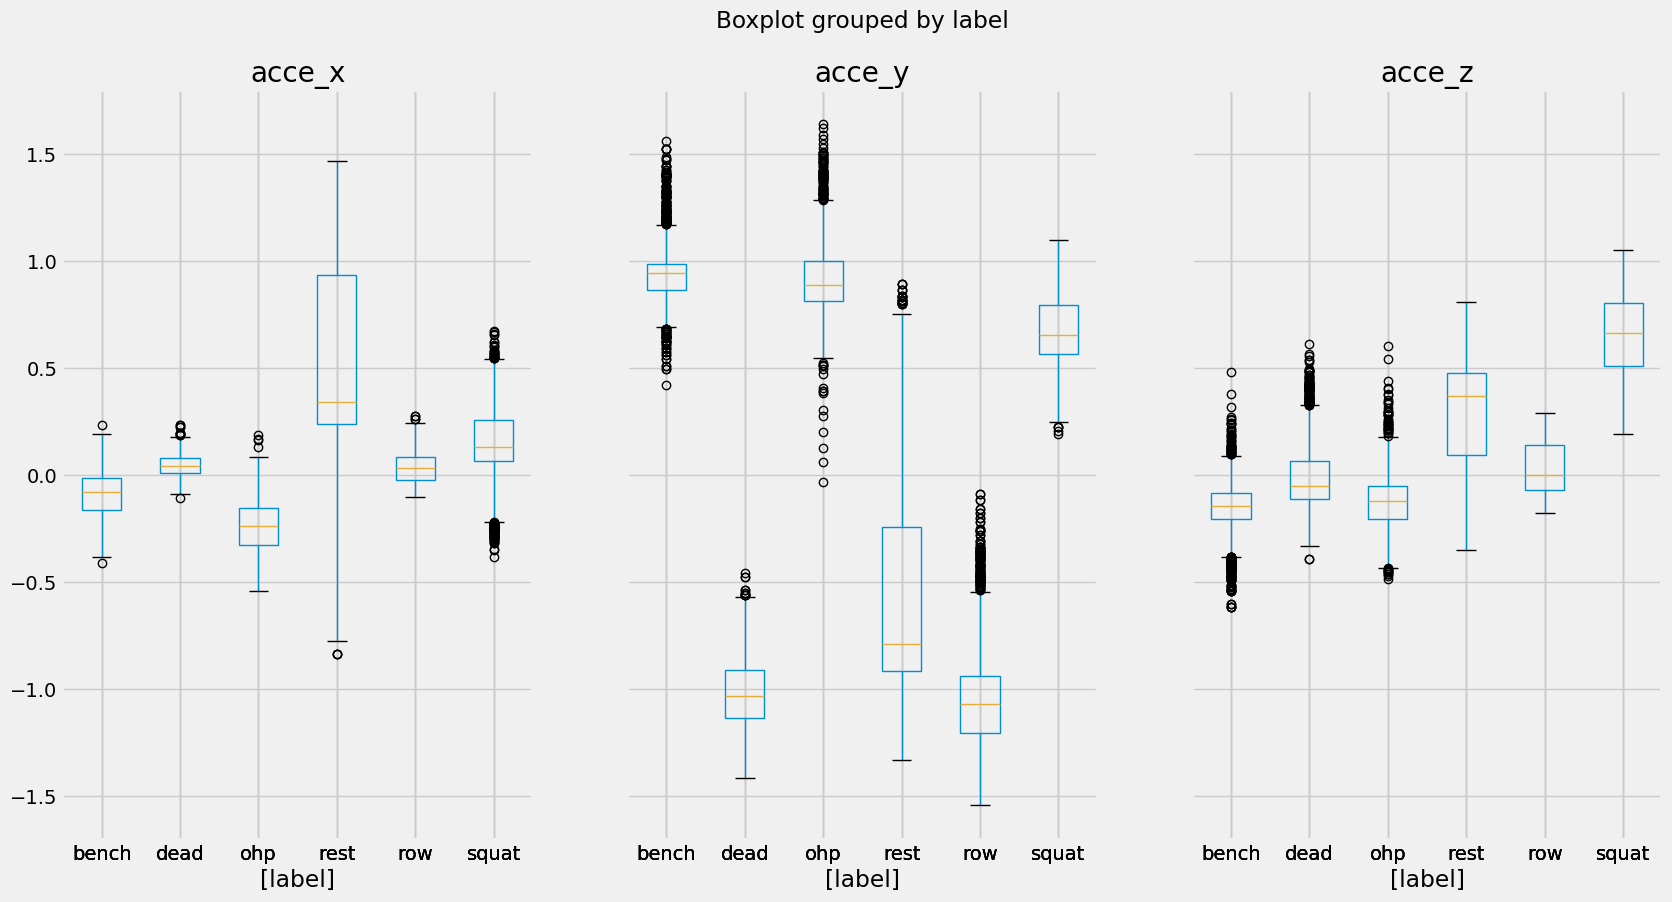

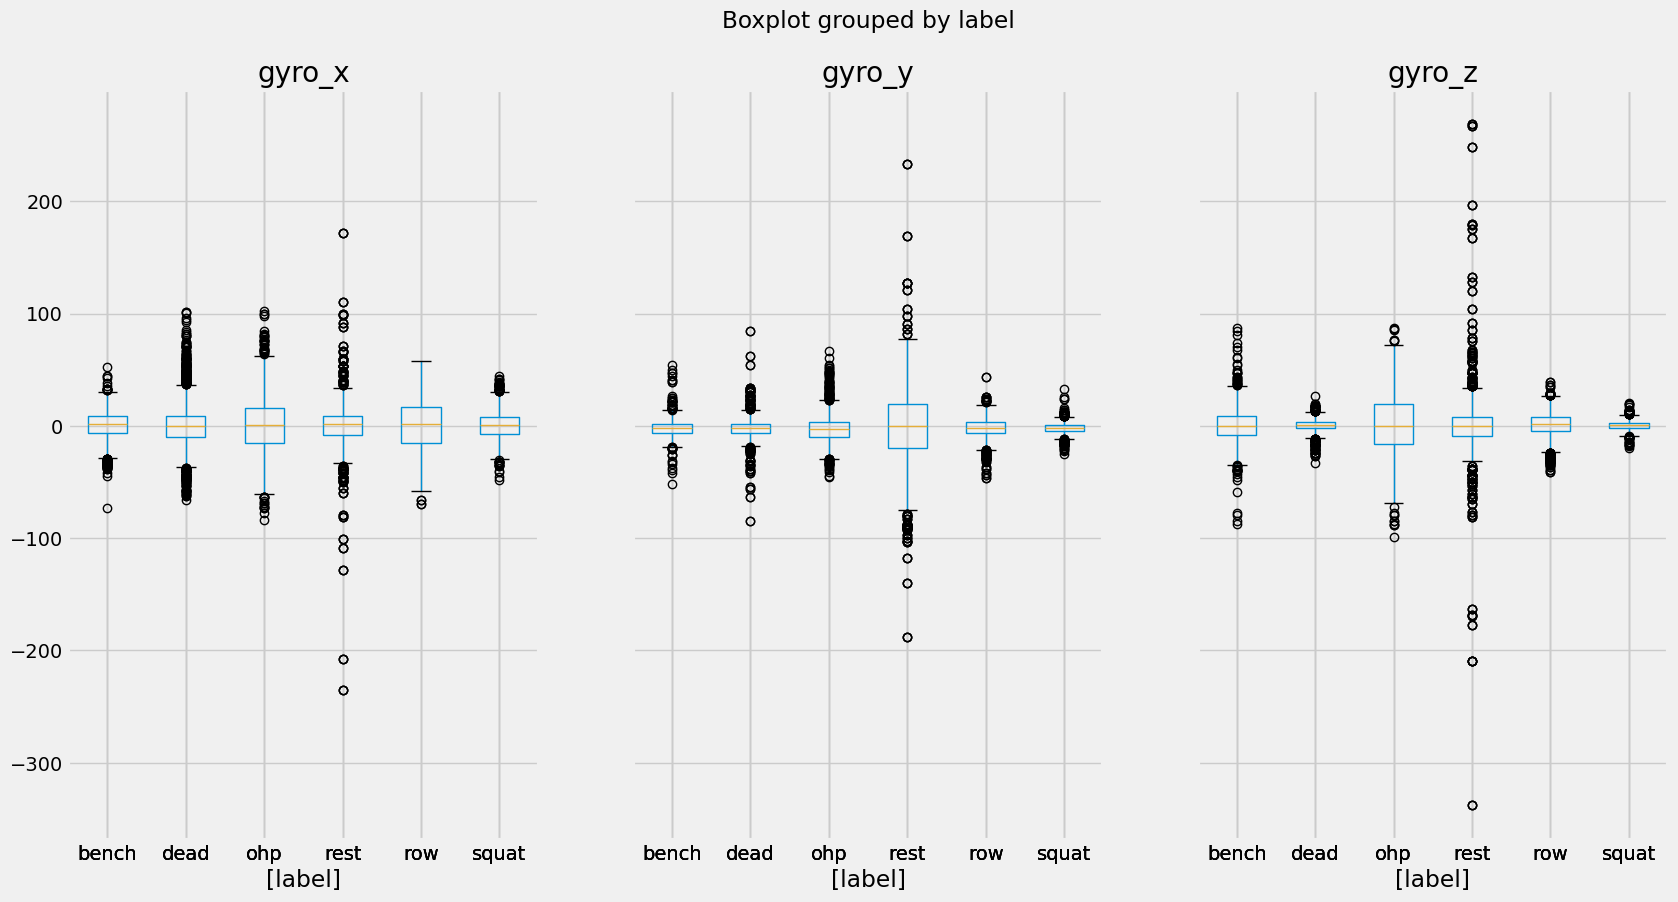

In [42]:
acceBoxPlot = df[outlierColumns[:3] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1,3))
gyroBoxPlot = df[outlierColumns[3:] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1,3))
plt.show()

In [45]:
def plotBinaryOutliers(dataset, col, outlier_col, reset_index):
    """ Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

    # Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

In [47]:
col = "acce_x"

In [49]:
dataset = markOutliersIQR(df, col)

In [50]:
dataset

acce_x    acce_y    acce_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  acce_x_outlier  
epoch (ms)                                                                
2019-01-11 15:08:05.200           B  bench    heavy   30           False  
2019-01-11 15:08:05.400           B  bench    heavy   30           False  
2019-01-11 15:08:05.600           B  bench    heavy   30           False  
2019-01-11 15:08:05.800           B  bench    heavy   30           False  
2019-01-11 15:08:06.000           B  bench    heavy   30           False  
...                             ...    ...      ...  ...             ...  
2019-01-20 17:33:27.000           E    row   medium   90           False  
2019-01-20 17:33:27.200           E    row   medium   90           False  
2019-01-20 17:33:27.400           E    row   medium   90           False  
2019-01-20 17:33:27.600           E    row   medium   90           False  
2019-01-20 17:33:27.800           E    row   medium   90           False  

[9009 rows x 11 columns]

In [51]:
df

acce_x    acce_y    acce_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  
epoch (ms)                                                
2019-01-11 15:08:05.200           B  bench    heavy   30  
2019-01-11 15:08:05.400           B  bench    heavy   30  
2019-01-11 15:08:05.600           B  bench    heavy   30  
2019-01-11 15:08:05.800           B  bench    heavy   30  
2019-01-11 15:08:06.000           B  bench    heavy   30  
...                             ...    ...      ...  ...  
2019-01-20 17:33:27.000           E    row   medium   90  
2019-01-20 17:33:27.200           E    row   medium   90  
2019-01-20 17:33:27.400           E    row   medium   90  
2019-01-20 17:33:27.600           E    row   medium   90  
2019-01-20 17:33:27.800           E    row   medium   90  

[9009 rows x 10 columns]

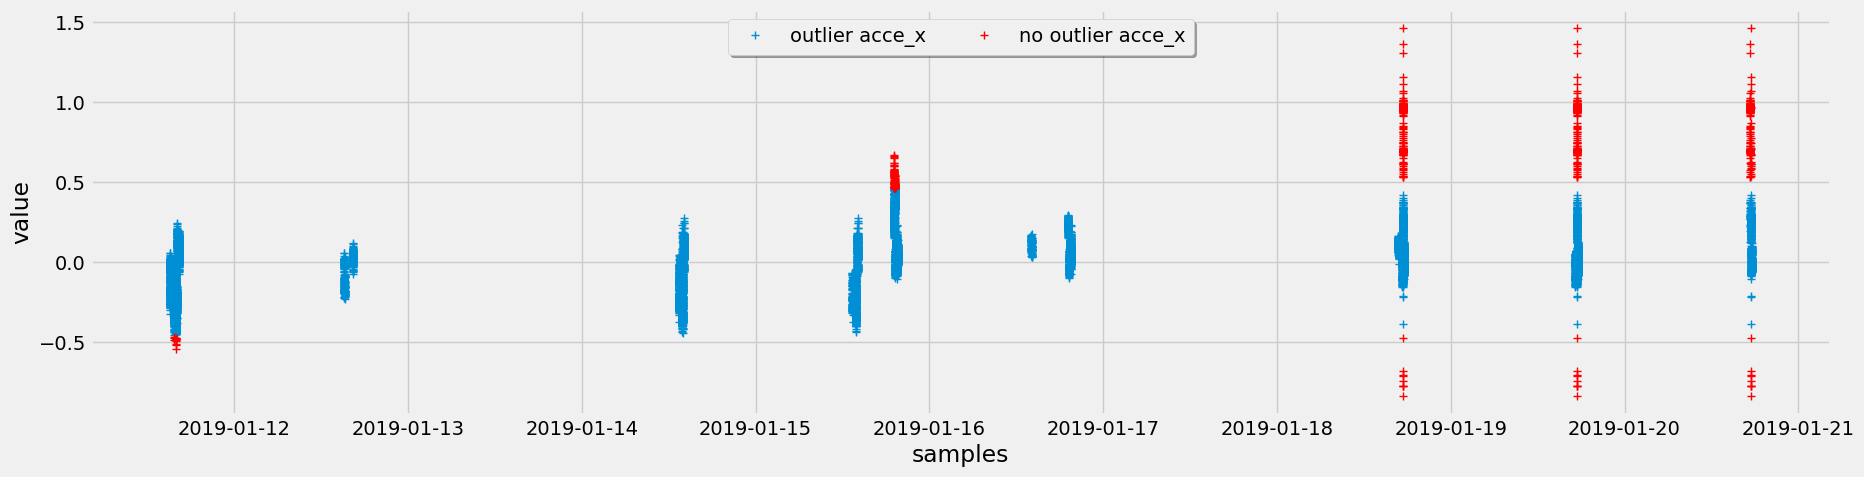

In [52]:
plotBinaryOutliers(dataset=dataset, col=col, outlier_col=col+"_outlier", reset_index=False)

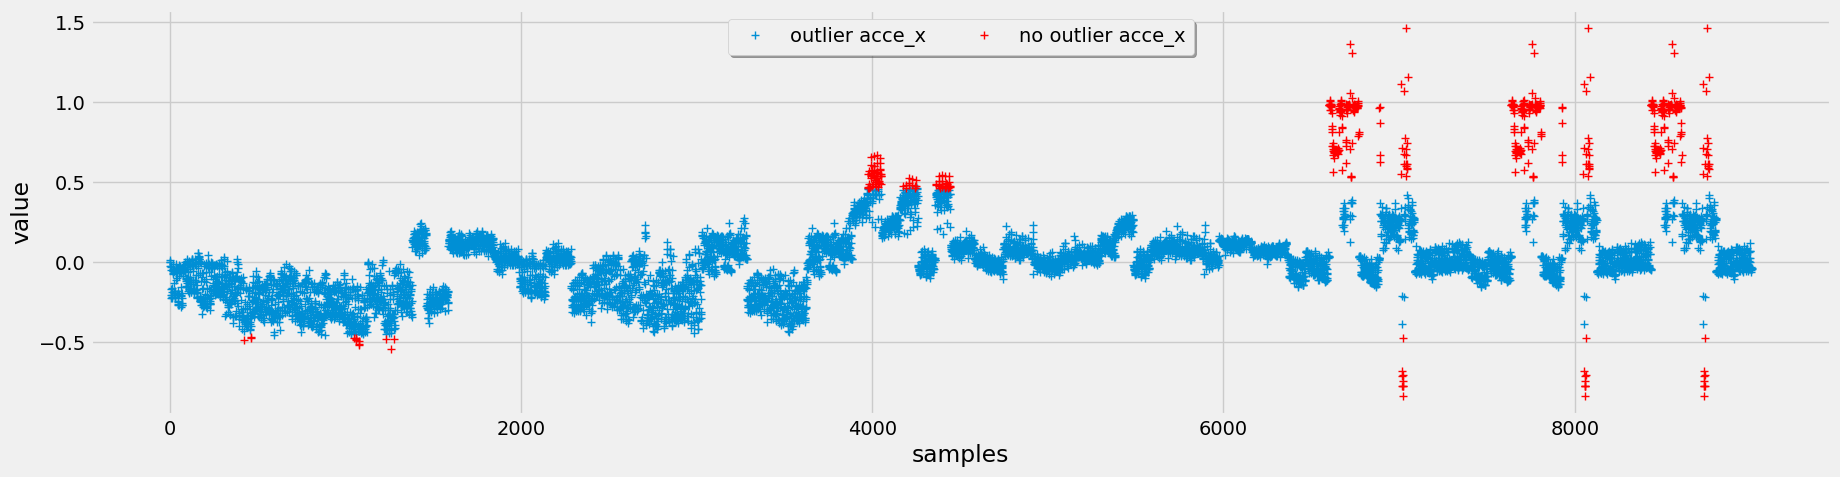

In [54]:
plotBinaryOutliers(
    dataset=dataset, 
    col=col, 
    outlier_col=col+"_outlier", 
    reset_index=True
    )

In [55]:
# The above code shows the difference between not resetting and resetting the index. Resetting the index gives us the samples (number of data that we have) and shows a more understandable data plots.

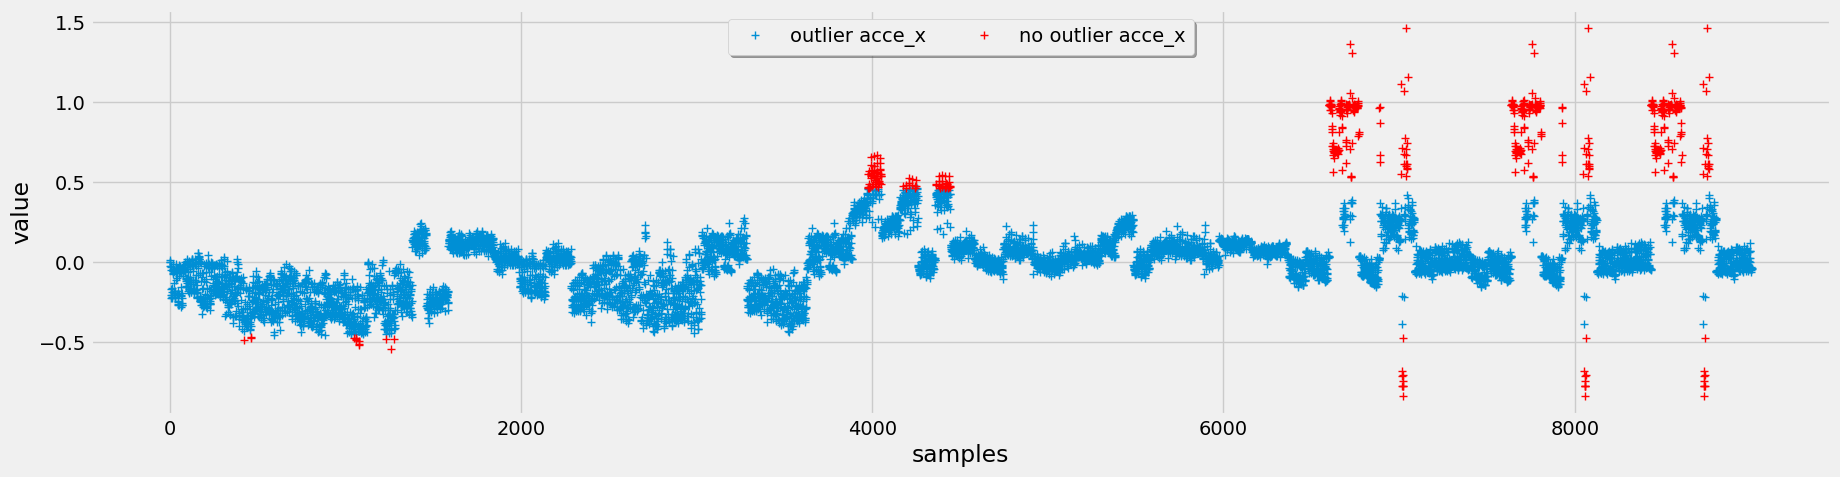

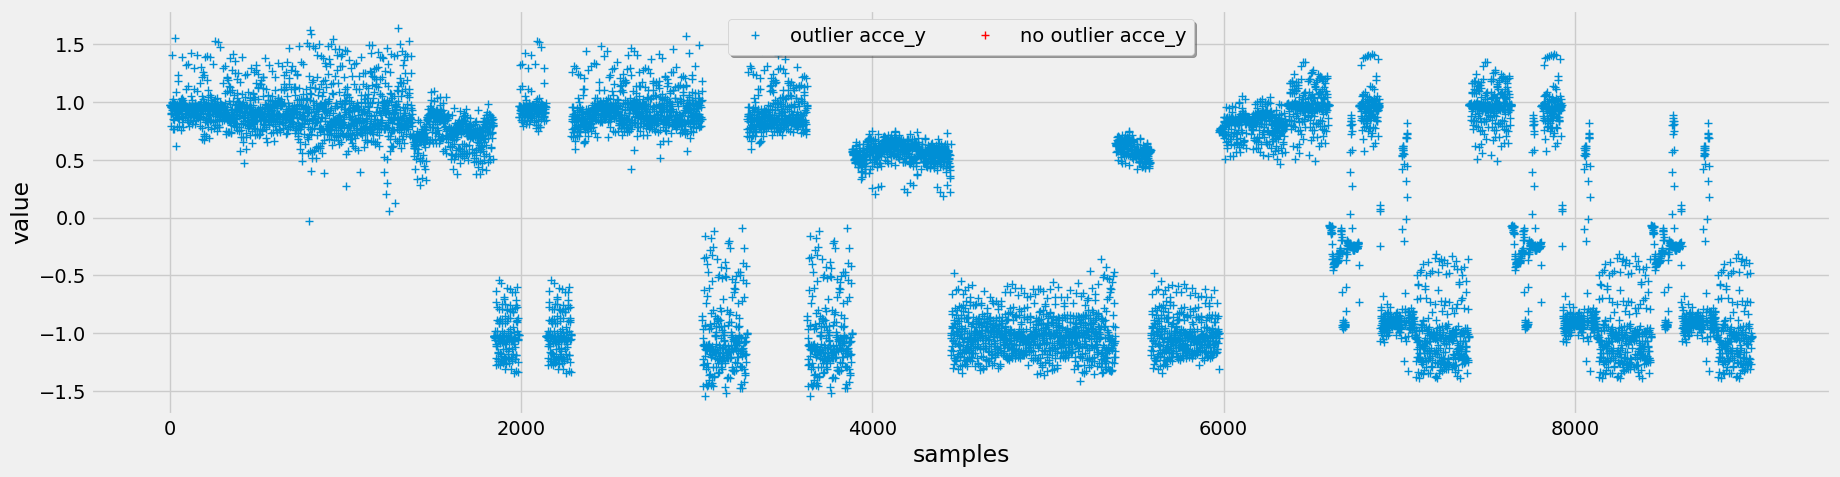

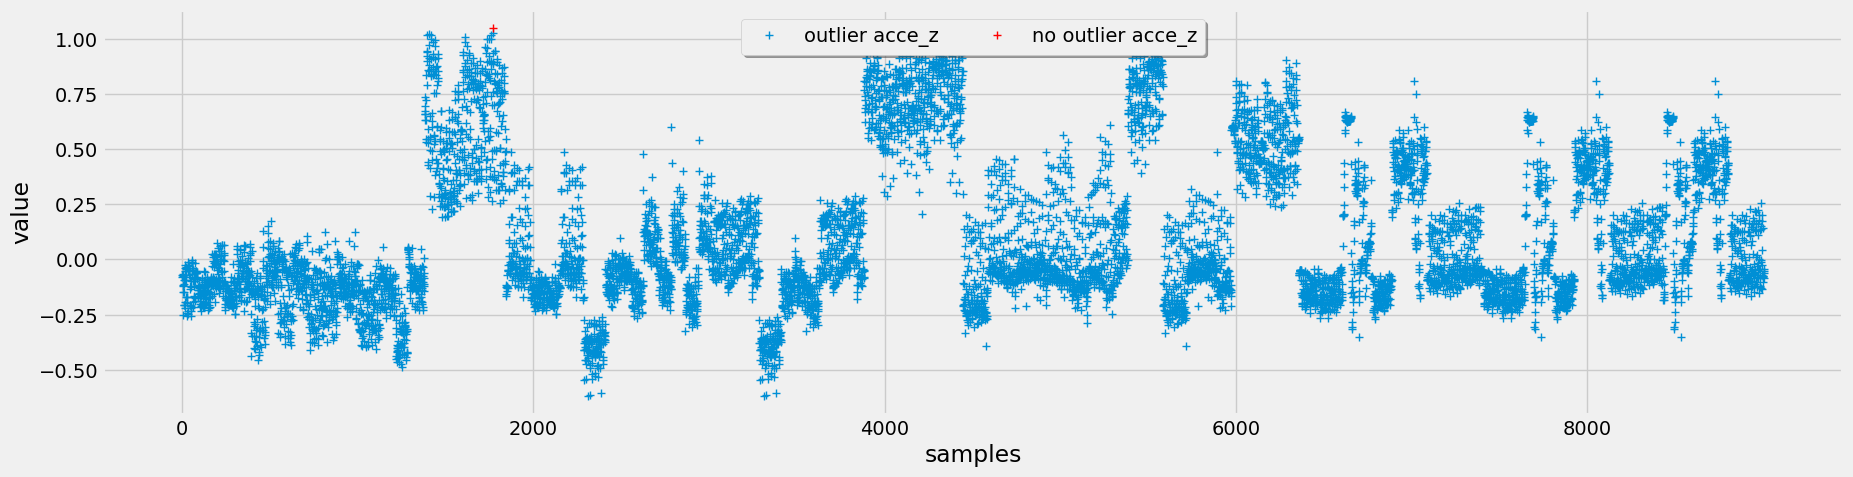

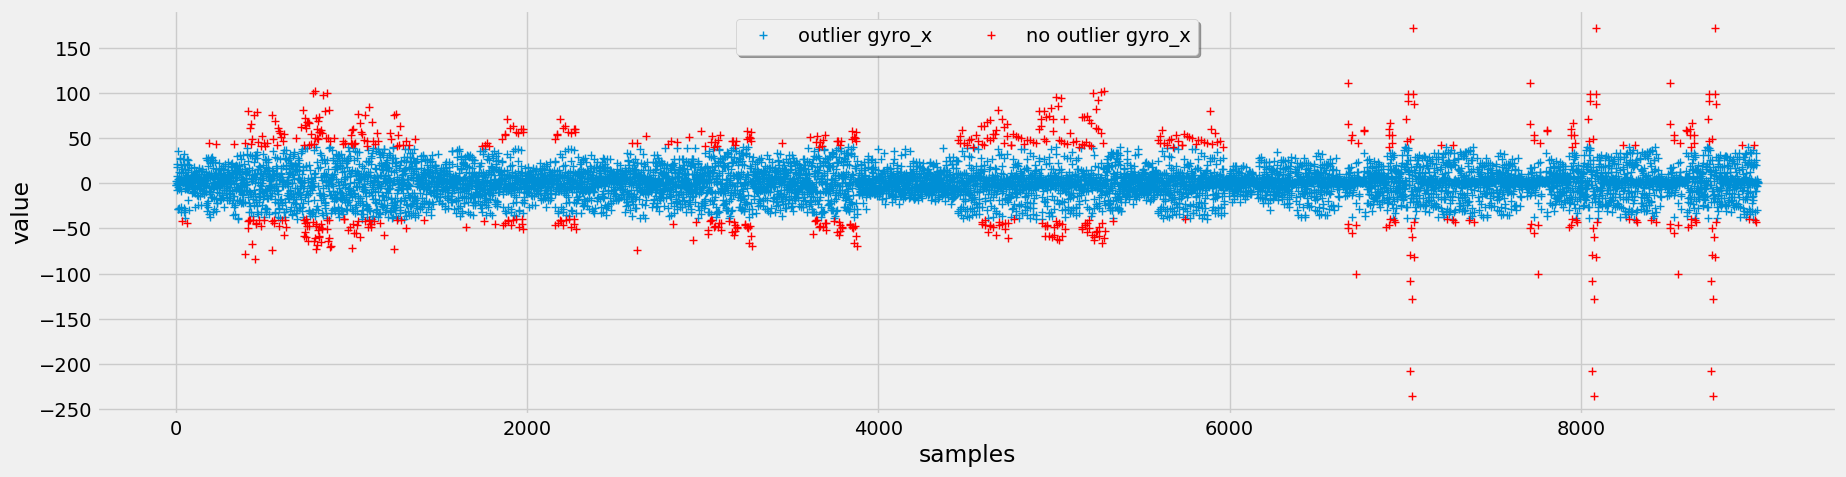

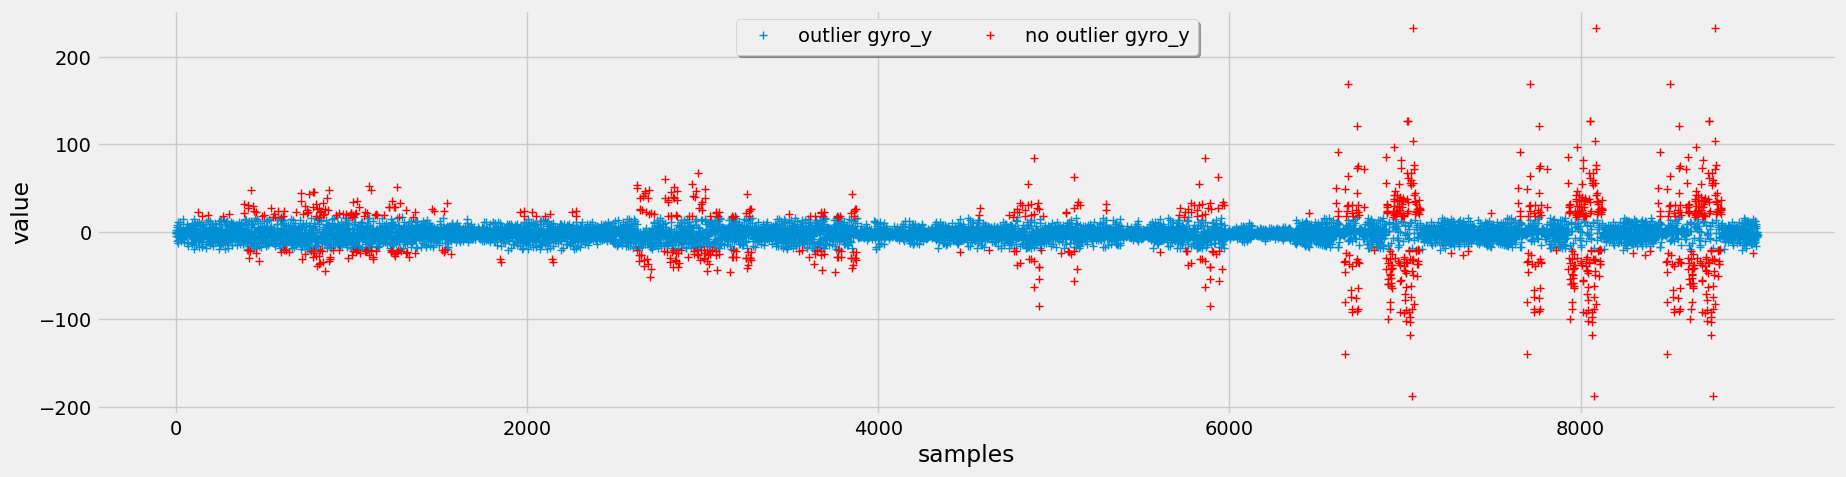

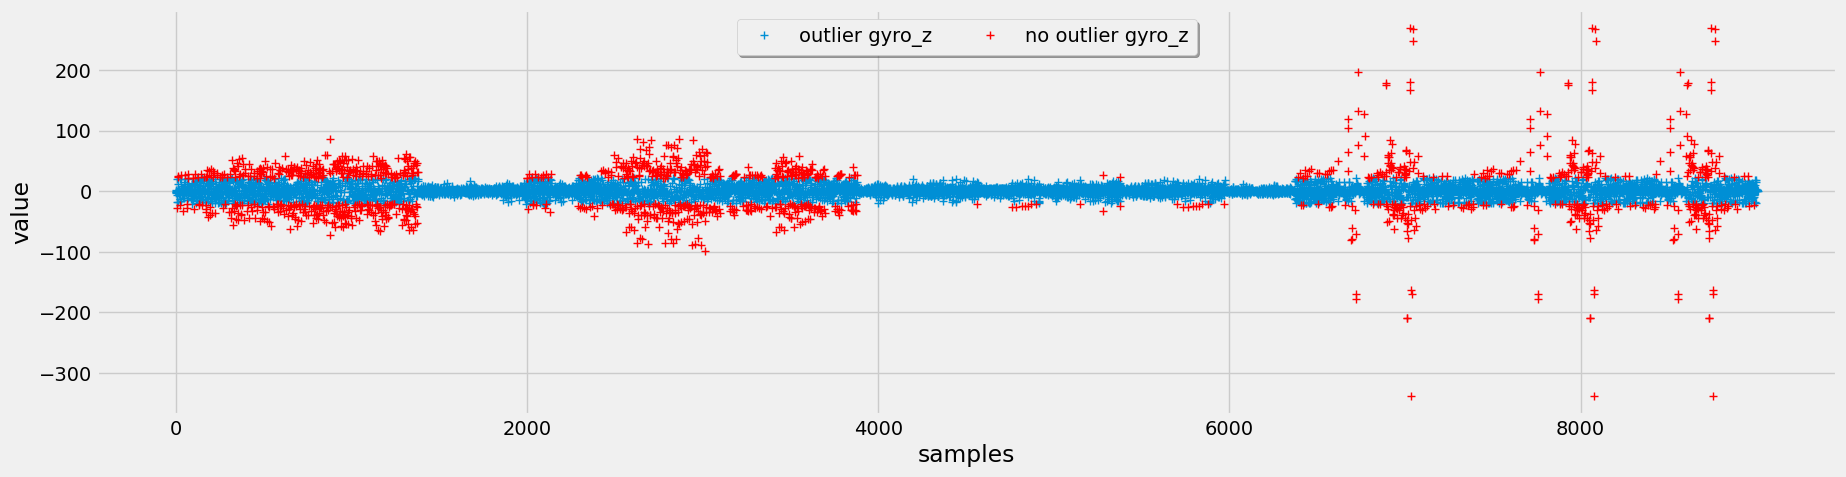

In [57]:
for perCol in outlierColumns:
    dataset = markOutliersIQR(df, perCol)
    plotBinaryOutliers(
        dataset=dataset, 
        col=perCol, 
        outlier_col=perCol+"_outlier", 
        reset_index=True
        )

In [58]:
# Remember, the above code is not filtered through each exercise. Therefore, it marks some data as outlier even if its not since the data it is measuring is the mean of all exercise. This needs to be filtered by each exercise.

In [59]:
# Before doing Chauvenet's function. We need to determine if the data is in normal distribution.

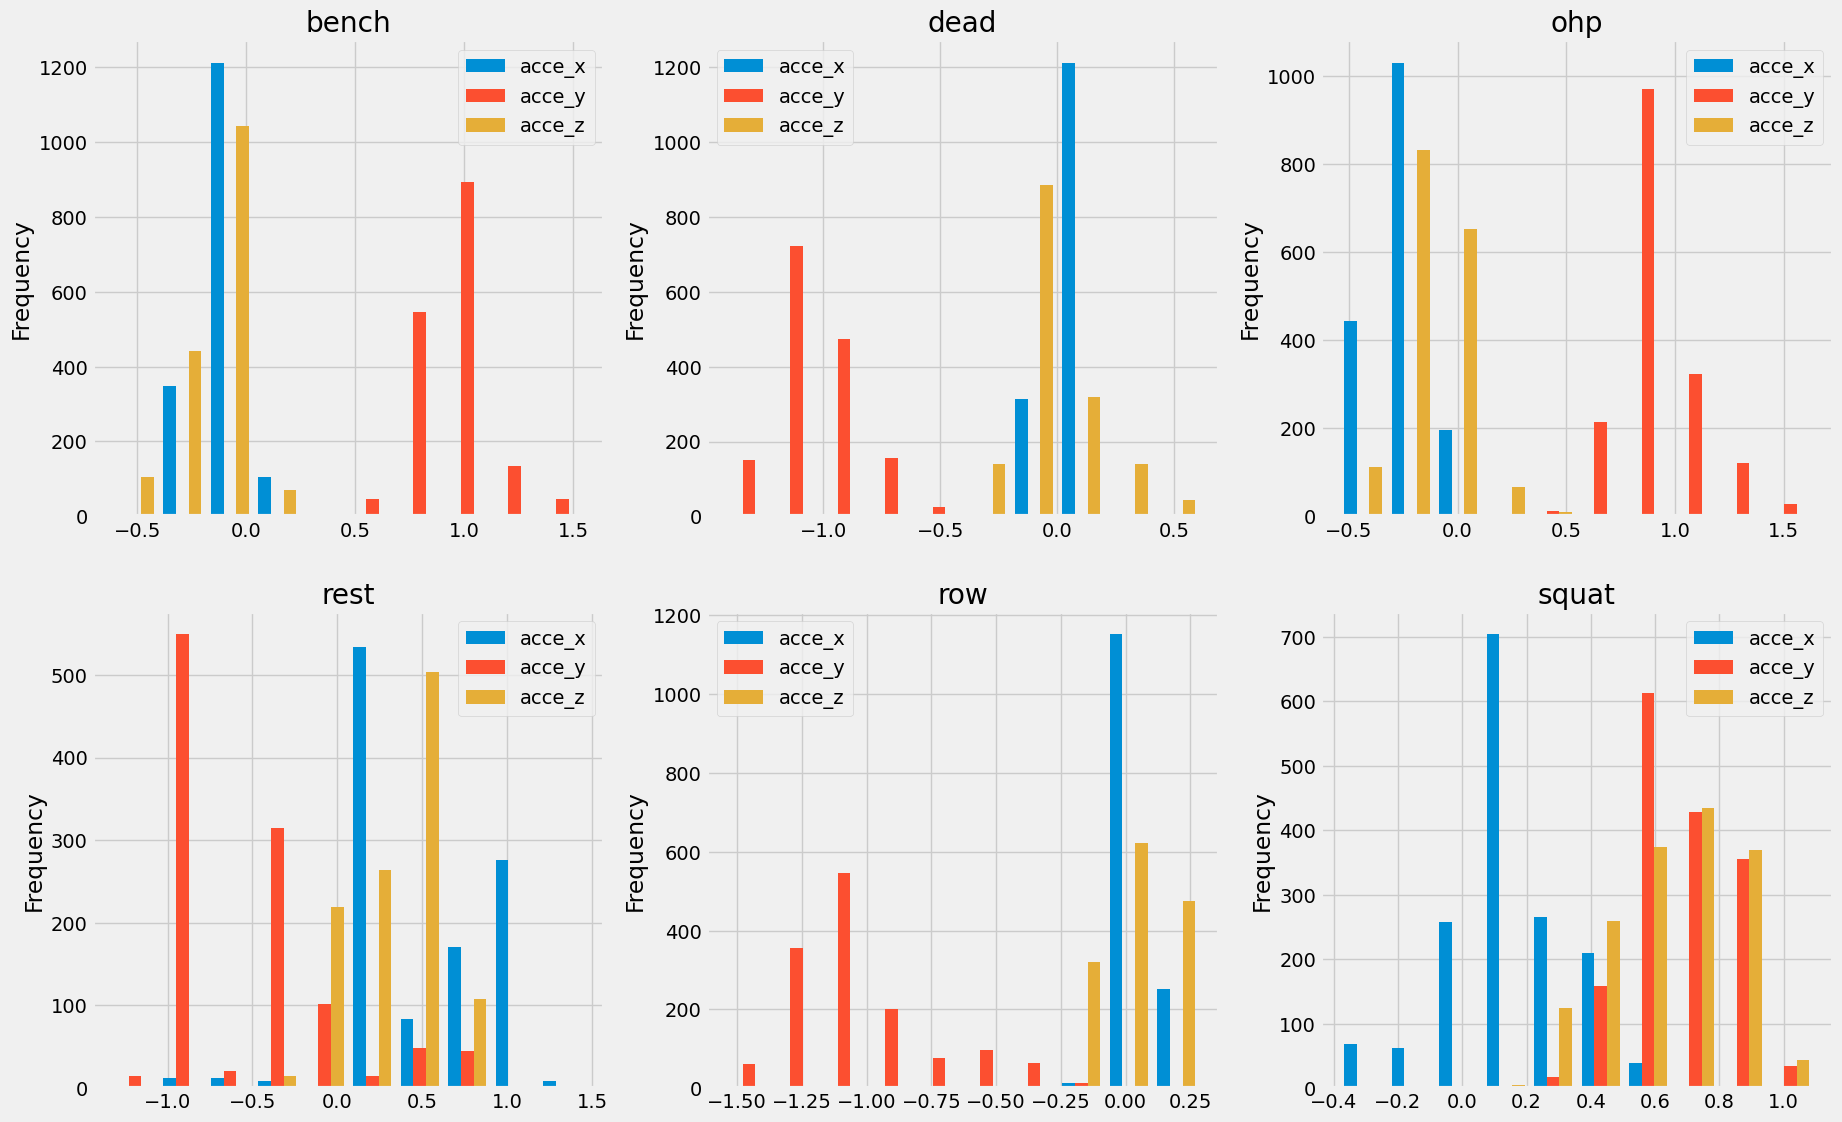

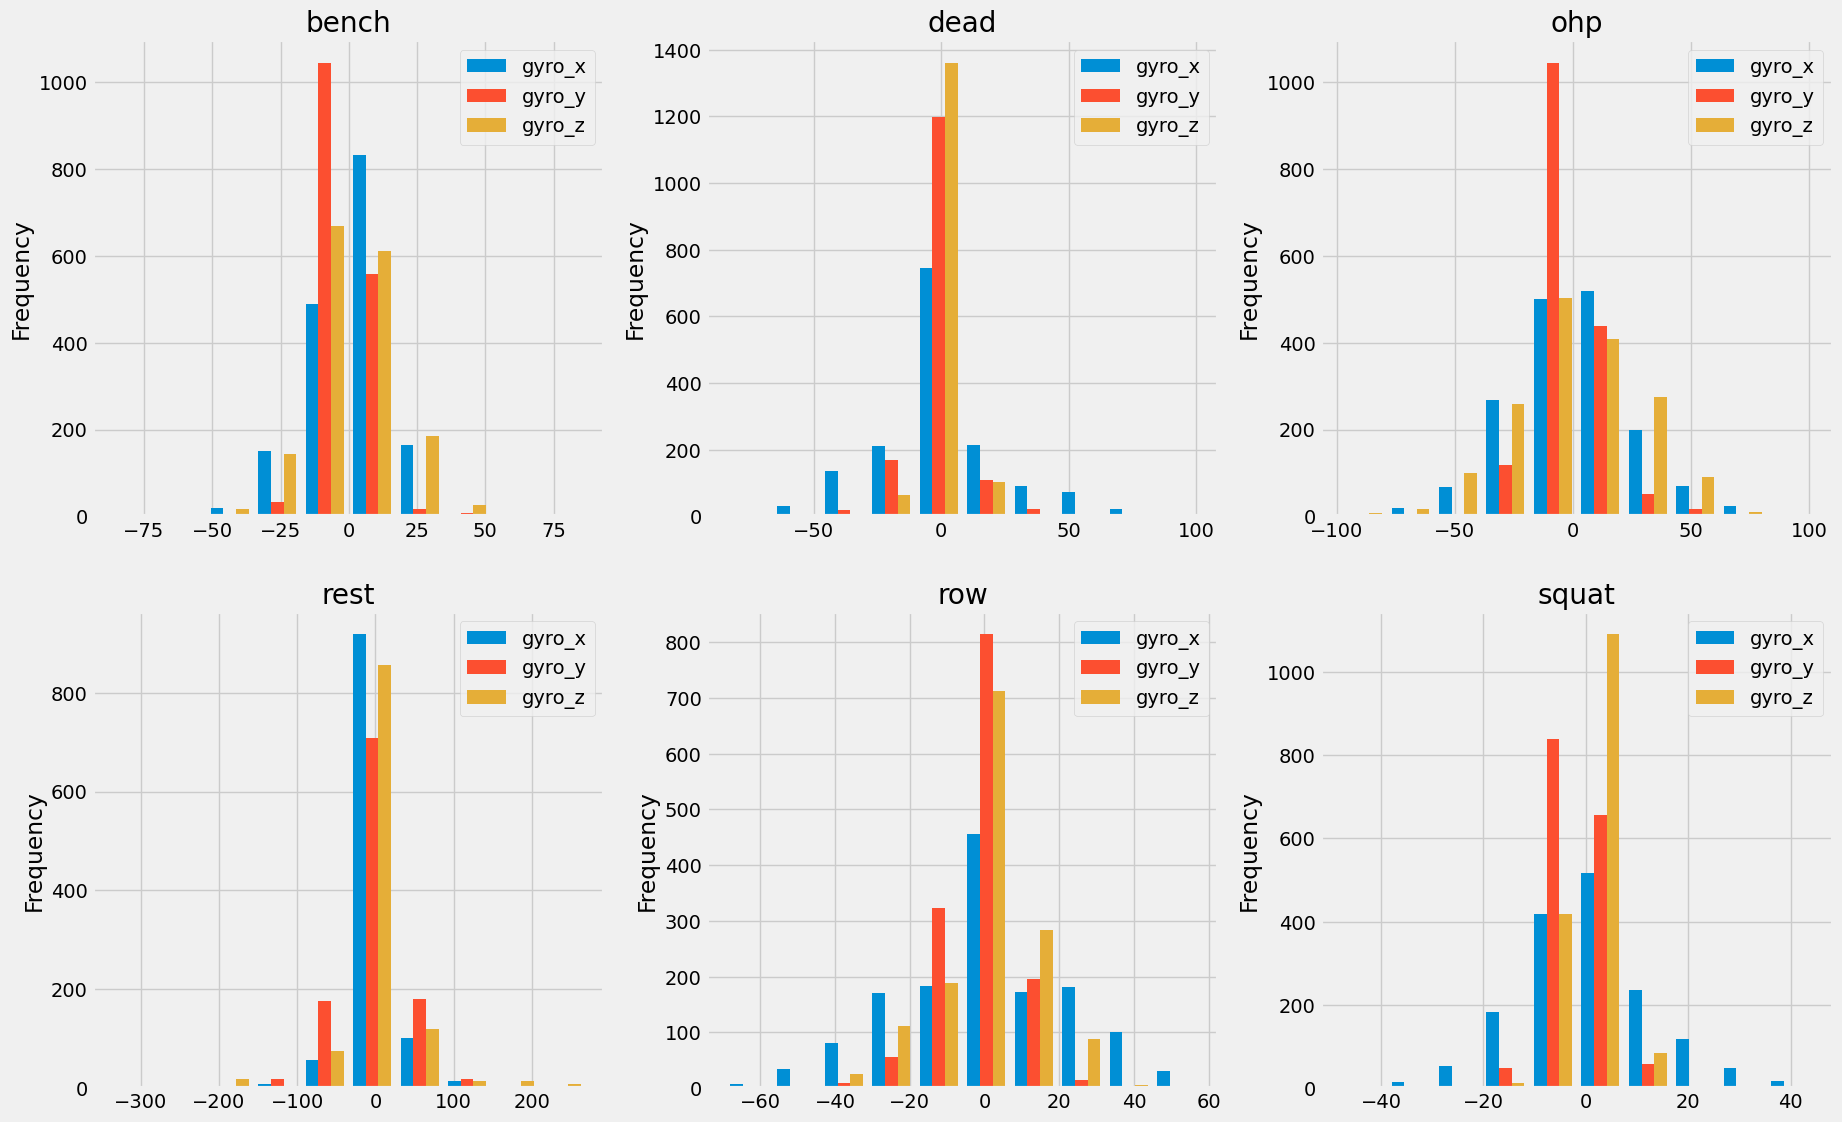

In [62]:
acceHistPot = df[outlierColumns[:3] + ["label"]].plot.hist(by="label", figsize=(20, 20), layout=(3,3))
gyroHistPot = df[outlierColumns[3:] + ["label"]].plot.hist(by="label", figsize=(20, 20), layout=(3,3))
plt.show()

In [63]:
# For the most part, it looks distributed except for the "rest" in accelerometer. normal distribution in histogram plot looks like a bell shape. Remember that.

In [64]:
def markOutliersChauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.
    
    Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption 
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset

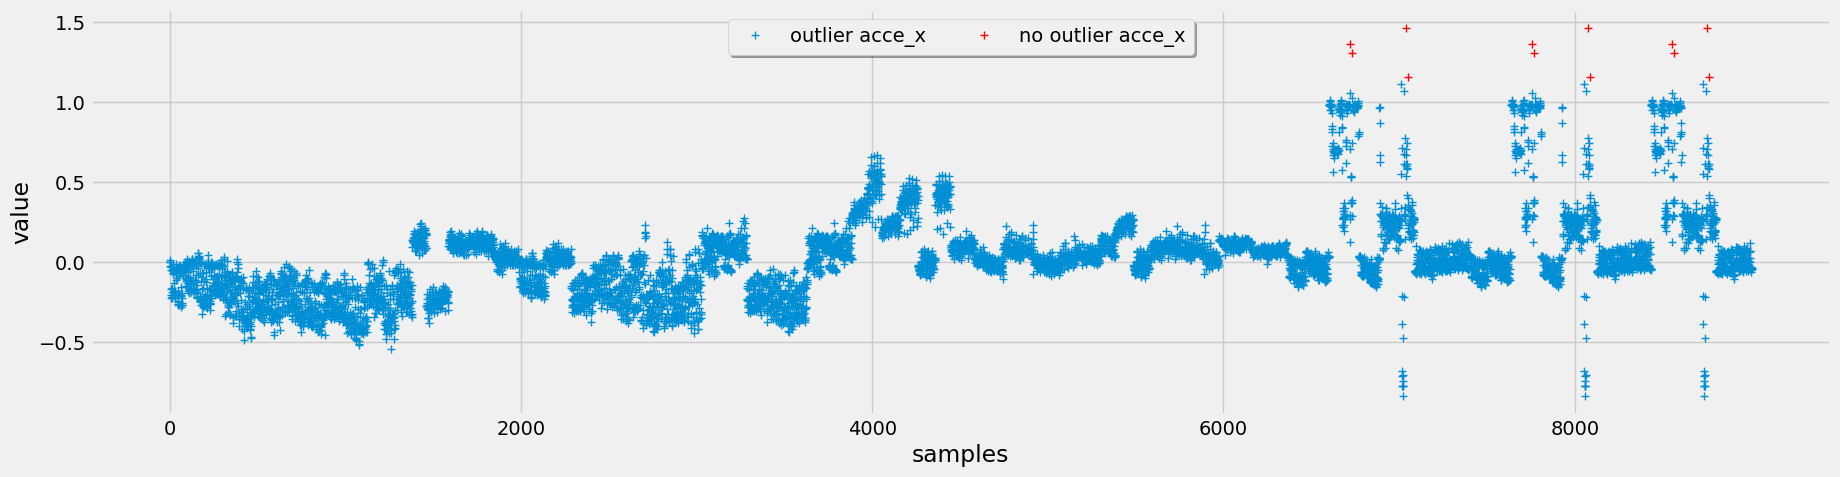

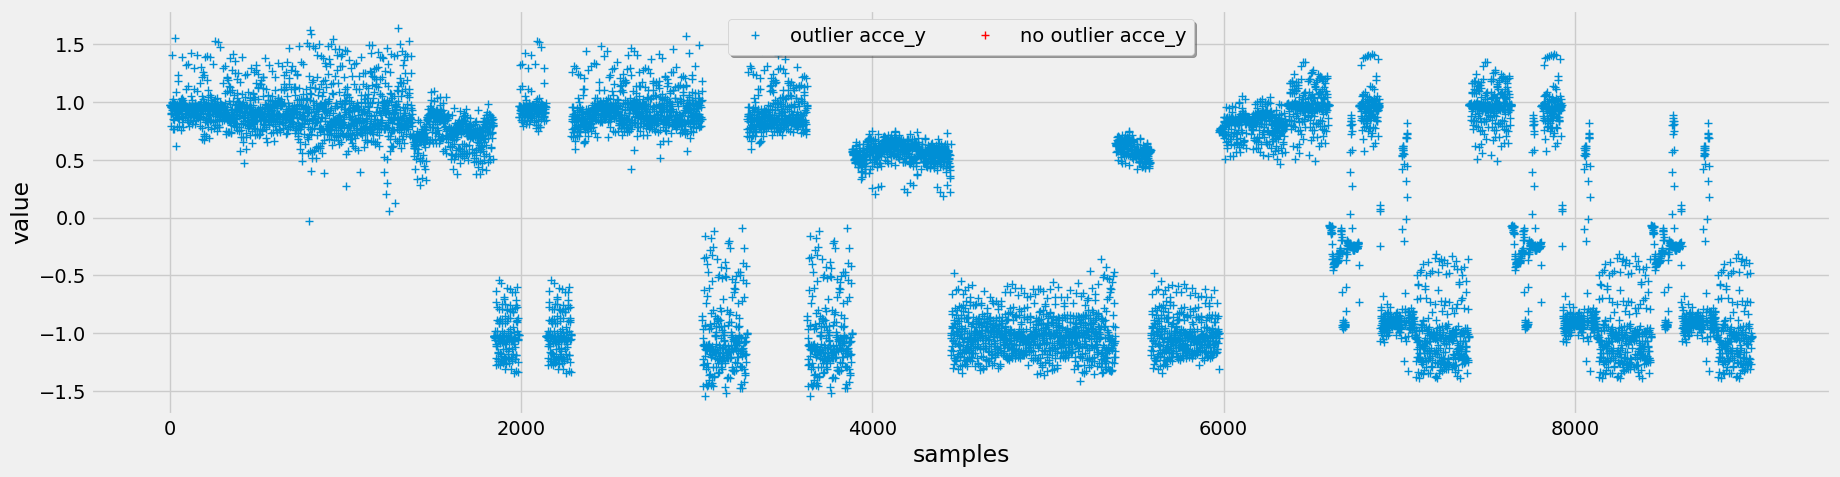

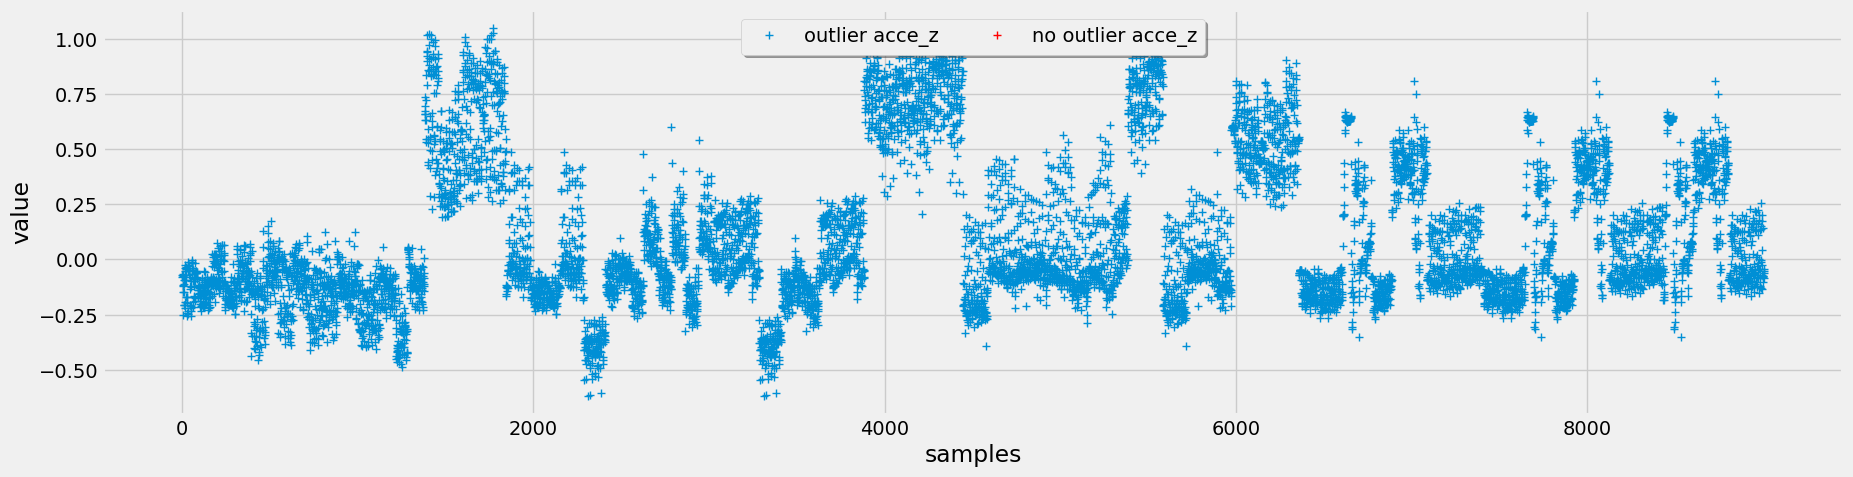

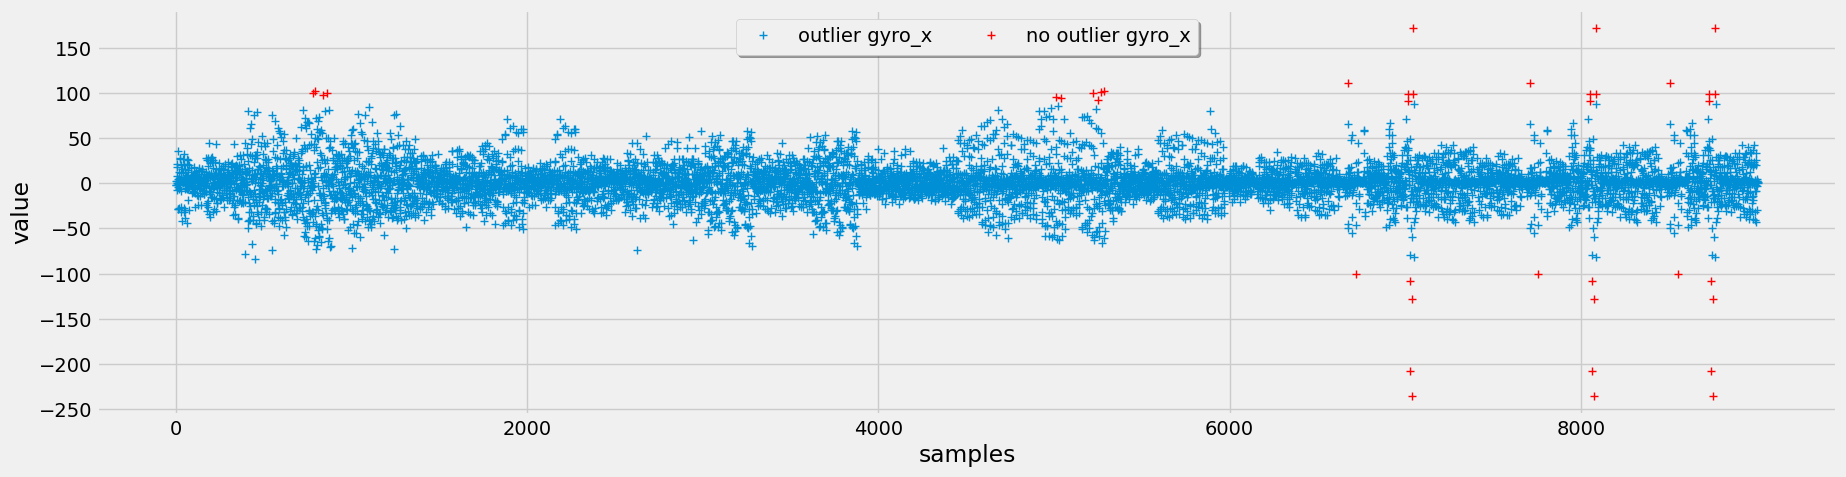

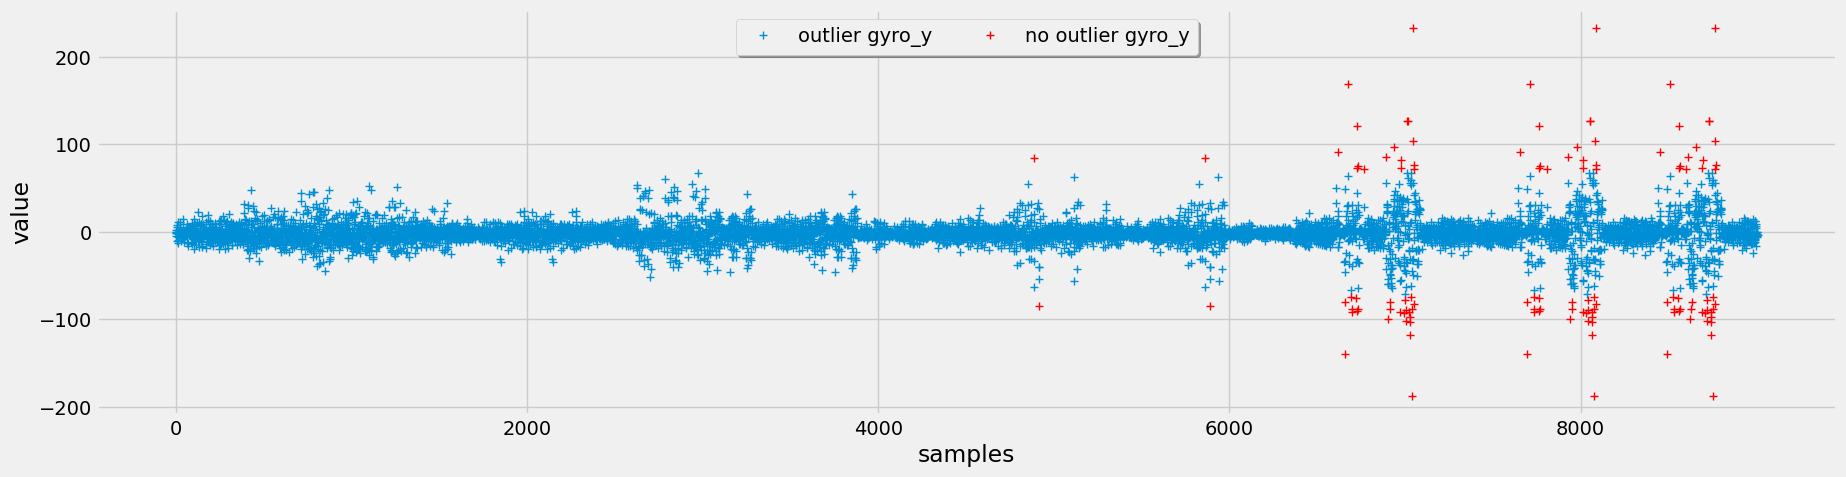

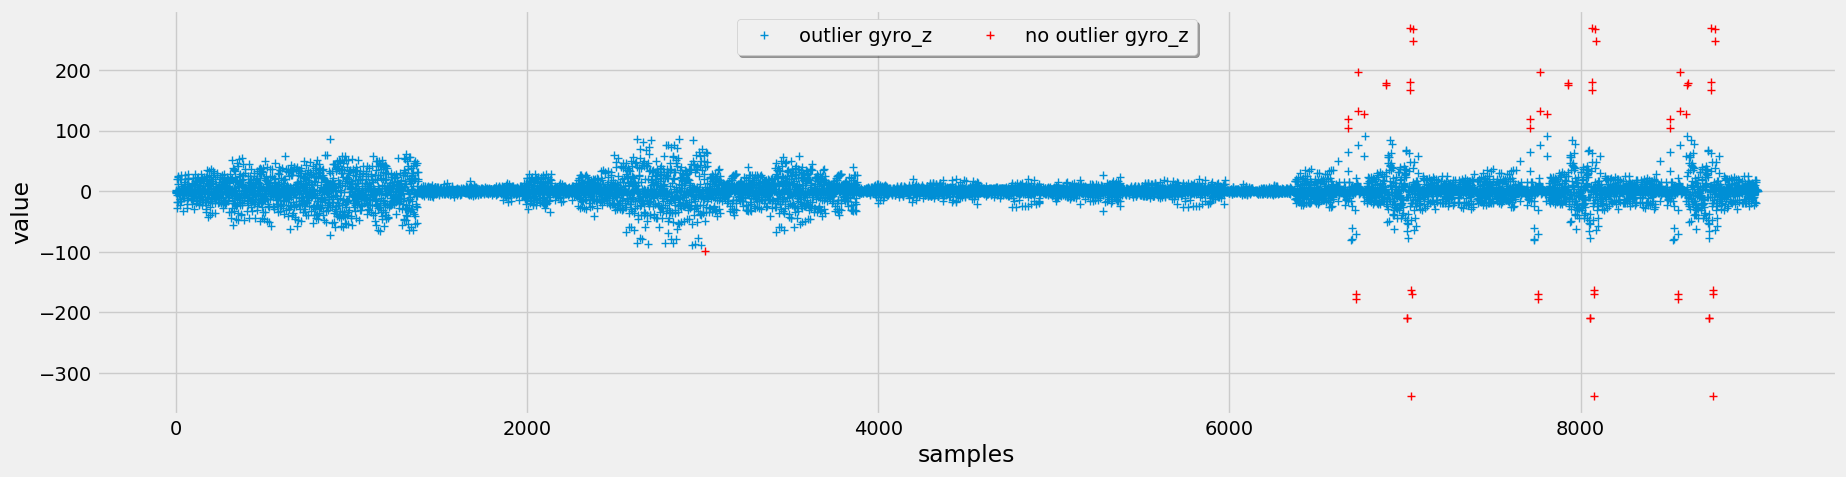

In [65]:
for perCol in outlierColumns:
    dataset = markOutliersChauvenet(df, perCol)
    plotBinaryOutliers(
        dataset=dataset, 
        col=perCol, 
        outlier_col=perCol+"_outlier", 
        reset_index=True
        )

In [66]:
# Chauvenet perform better than IQR. But remember, this data represents all the exercise and is not filtered to each exercise. So, it is still better to make this plot per exercise so that the ouliers is as precise as possible.

In [67]:
def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.
    
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """
    
    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores

In [68]:
dataset, outliers, xScores = mark_outliers_lof(df, outlierColumns)

In [69]:
dataset

acce_x    acce_y    acce_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  outlier_lof  
epoch (ms)                                                             
2019-01-11 15:08:05.200           B  bench    heavy   30        False  
2019-01-11 15:08:05.400           B  bench    heavy   30        False  
2019-01-11 15:08:05.600           B  bench    heavy   30        False  
2019-01-11 15:08:05.800           B  bench    heavy   30        False  
2019-01-11 15:08:06.000           B  bench    heavy   30        False  
...                             ...    ...      ...  ...          ...  
2019-01-20 17:33:27.000           E    row   medium   90        False  
2019-01-20 17:33:27.200           E    row   medium   90        False  
2019-01-20 17:33:27.400           E    row   medium   90        False  
2019-01-20 17:33:27.600           E    row   medium   90        False  
2019-01-20 17:33:27.800           E    row   medium   90        False  

[9009 rows x 11 columns]

In [70]:
outliers

array([1, 1, 1, ..., 1, 1, 1])

In [71]:
xScores

array([-1.02773582, -1.07699558, -1.15029777, ..., -0.99433498,
       -0.98962988, -0.98354443])

In [72]:
# For xScores, the more negative the value is, the less likely it is a outlier data.

In [74]:
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """ Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

    # Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

In [75]:
# Renamed the copied functions to its original name. Since I've learned that, that is the standard and I should not be messing those names. Especially in a team settings, let things as it should be or in a proper coding practice.

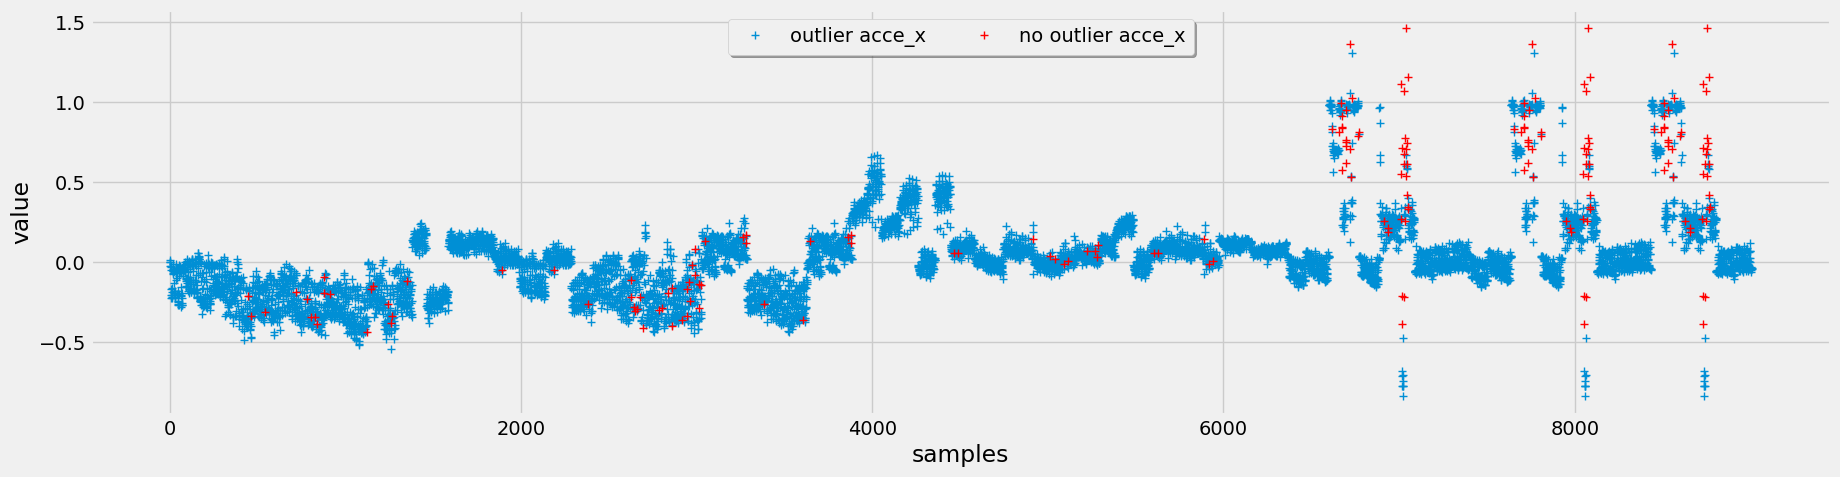

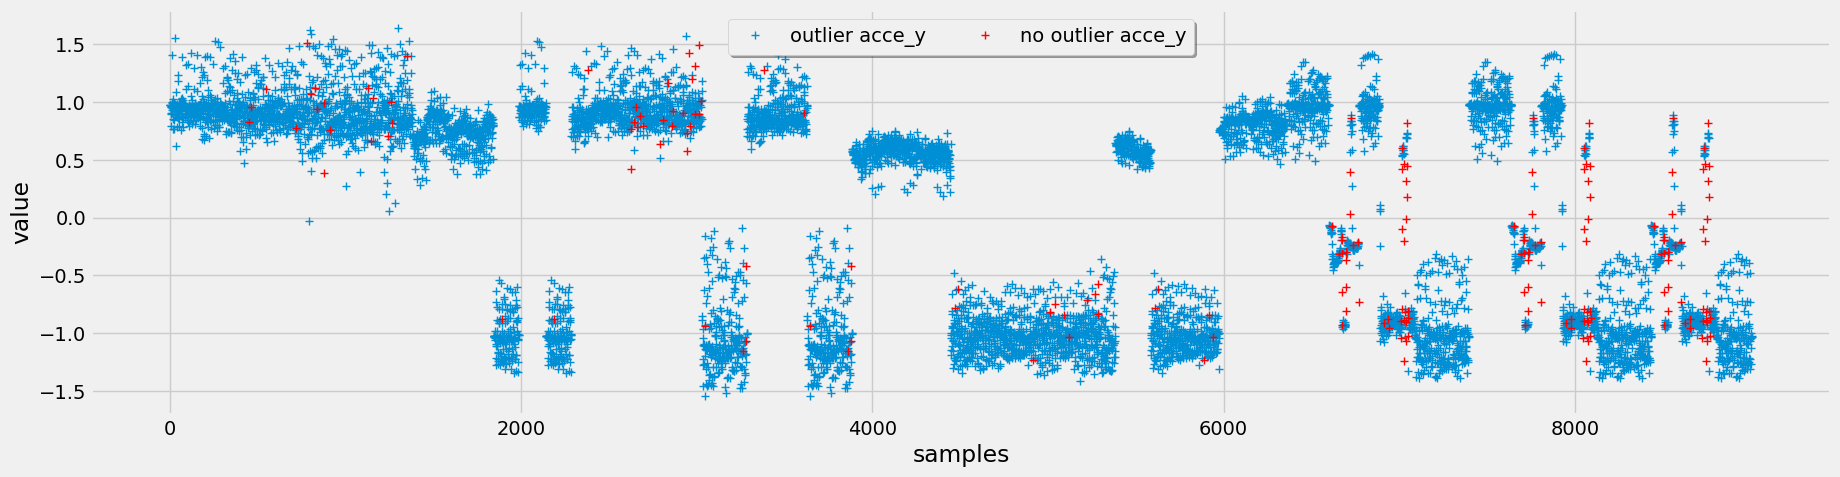

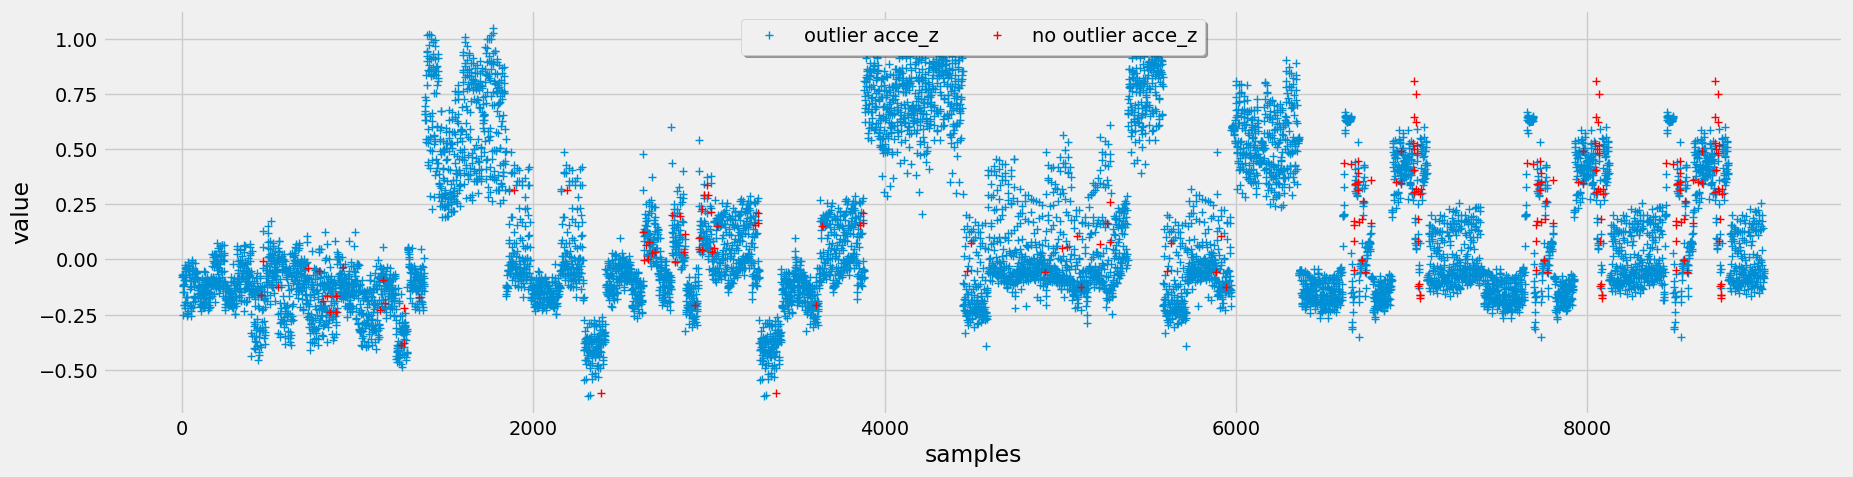

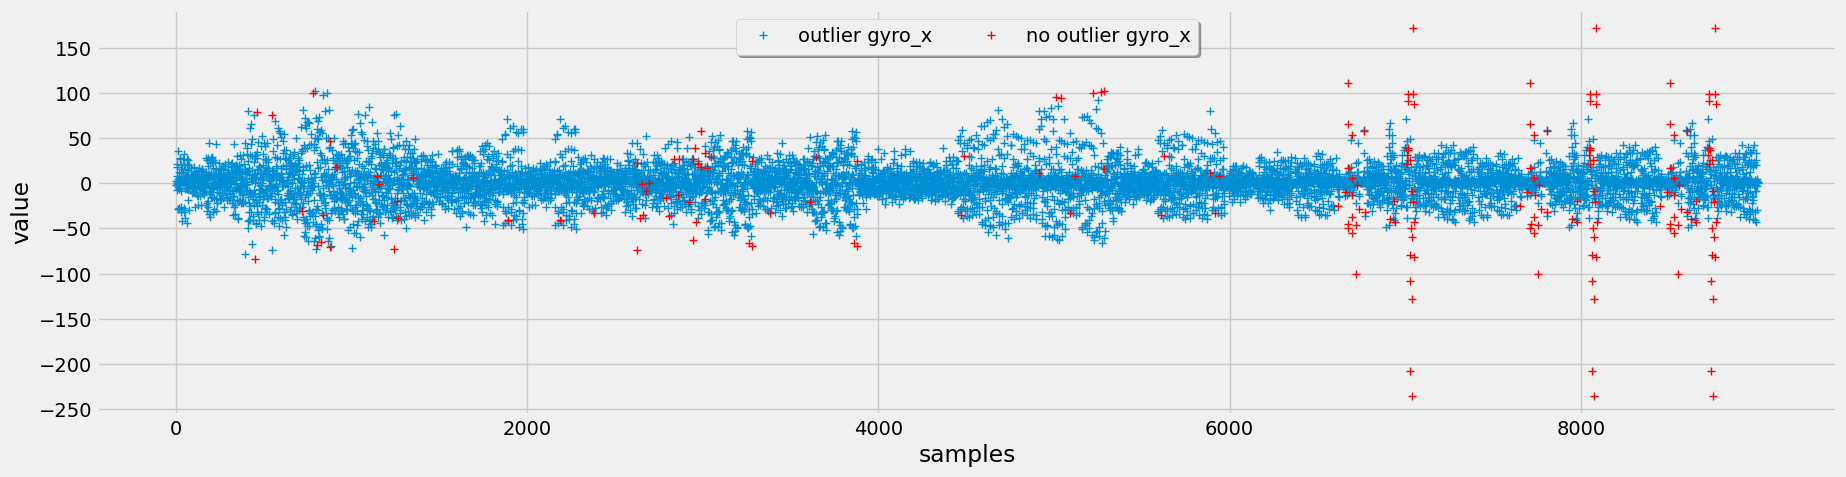

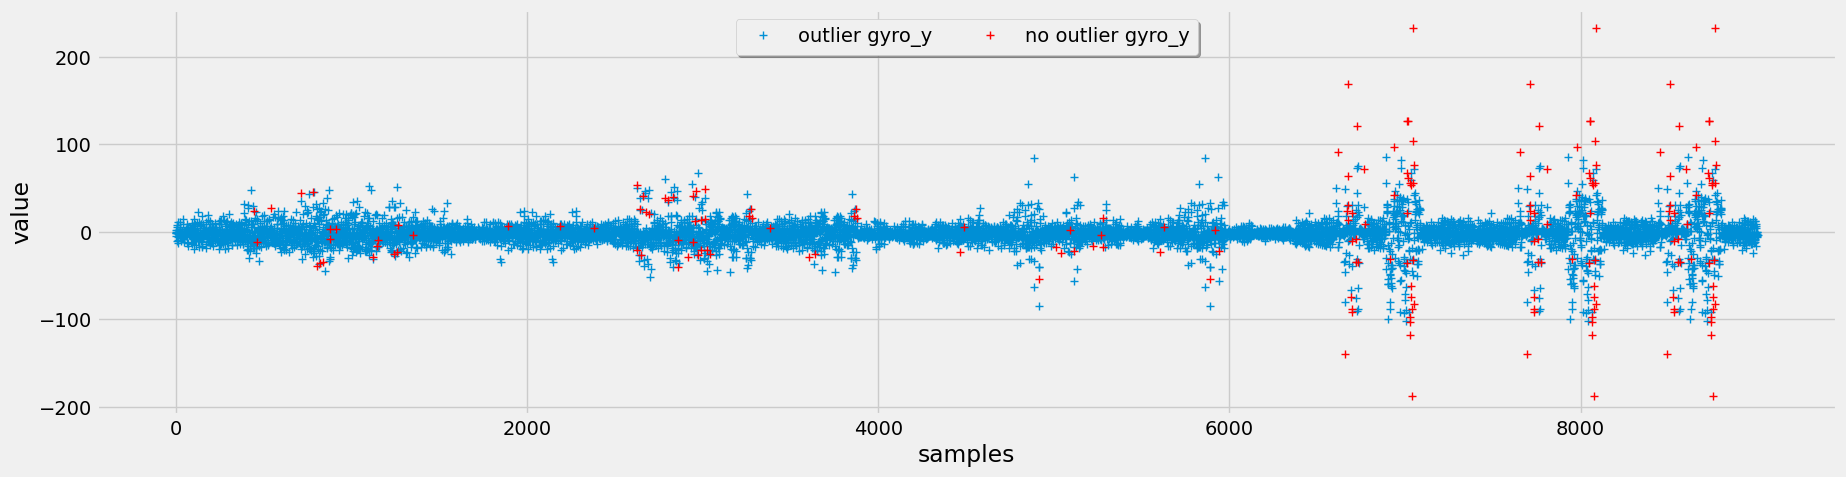

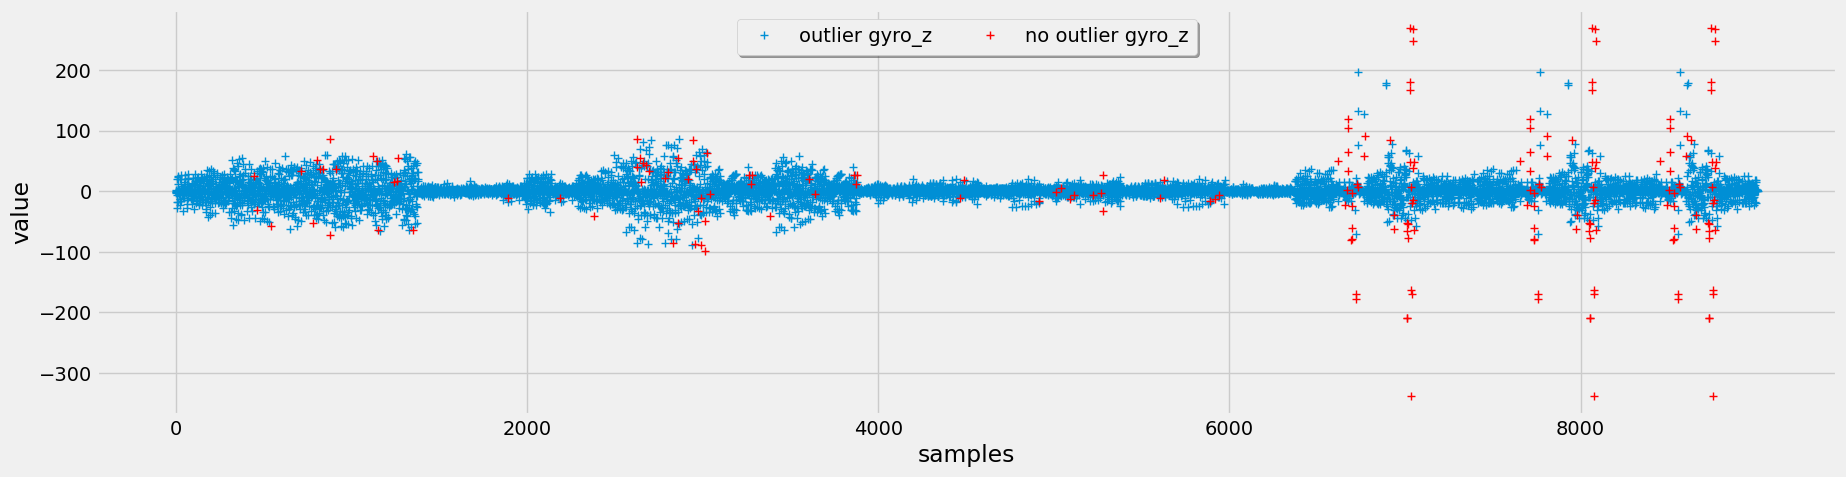

In [76]:
for perCol in outlierColumns:
    plot_binary_outliers(
        dataset=dataset, 
        col=perCol, 
        outlier_col="outlier_lof", 
        reset_index=True
        )

In [77]:
# Manual filtering to selected exercise type.

In [78]:
label = "bench"

In [79]:
df[df["label"] == label]

acce_x    acce_y    acce_z    gyro_x    gyro_y  \
epoch (ms)                                                                  
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.890400  2.439200   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.682600 -0.890400   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.560800 -0.256000   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.061000 -4.524400   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.439000 -1.548600   
...                           ...       ...       ...       ...       ...   
2019-01-19 17:24:41.800  0.013000  1.026667 -0.096333 -1.268400  2.841600   
2019-01-19 17:24:42.000  0.017500  0.955000 -0.075000  0.451200  0.024400   
2019-01-19 17:24:42.200  0.023667  0.964000 -0.086333  1.475600 -0.024200   
2019-01-19 17:24:42.400  0.026000  0.989000 -0.097000  2.756400 -3.121600   
2019-01-19 17:24:42.600  0.025000  0.978000 -0.092500  1.971333 -2.357667   

                         gyro_z participant  label category  set  
epoch (ms)                                                        
2019-01-11 15:08:05.200  0.9388           B  bench    heavy   30  
2019-01-11 15:08:05.400  2.1708           B  bench    heavy   30  
2019-01-11 15:08:05.600 -1.4146           B  bench    heavy   30  
2019-01-11 15:08:05.800 -2.0730           B  bench    heavy   30  
2019-01-11 15:08:06.000 -3.6098           B  bench    heavy   30  
...                         ...         ...    ...      ...  ...  
2019-01-19 17:24:41.800  2.0610           E  bench   medium   71  
2019-01-19 17:24:42.000  0.5242           E  bench   medium   71  
2019-01-19 17:24:42.200  1.5974           E  bench   medium   71  
2019-01-19 17:24:42.400 -0.8416           E  bench   medium   71  
2019-01-19 17:24:42.600  1.8090           E  bench   medium   71  

[1665 rows x 10 columns]

In [81]:
# Below uses the IQR function to plot label == bench

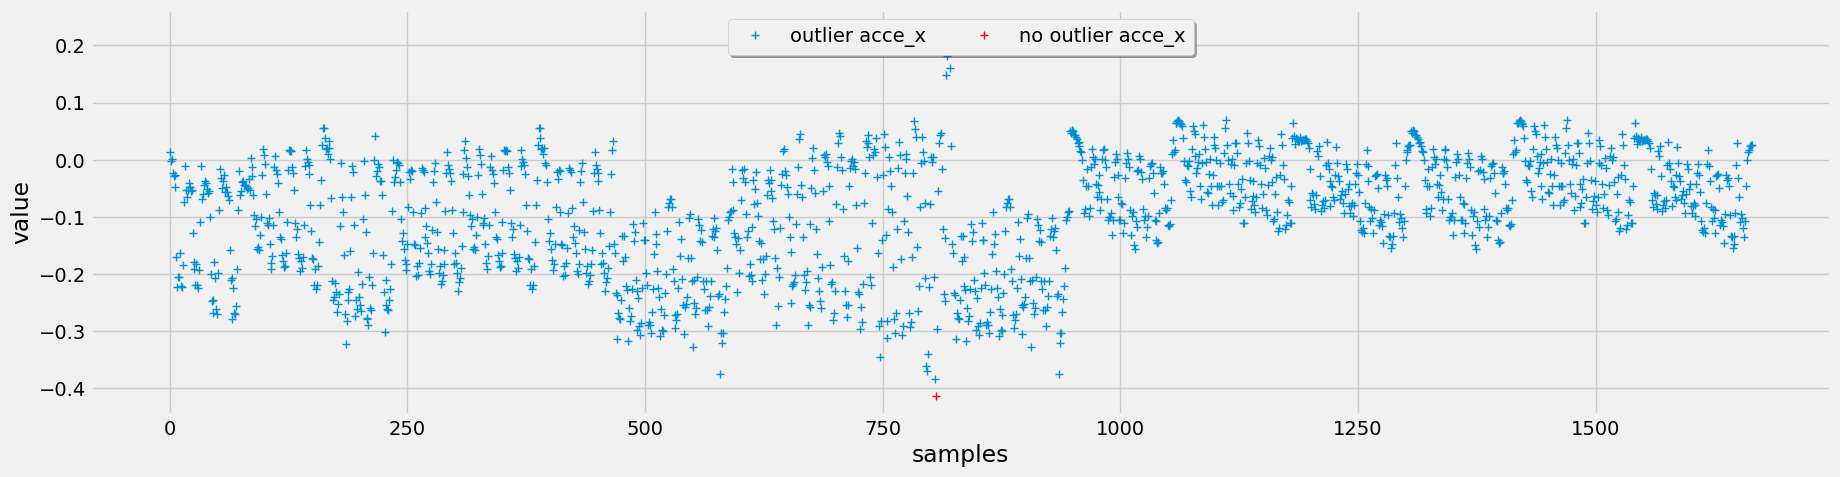

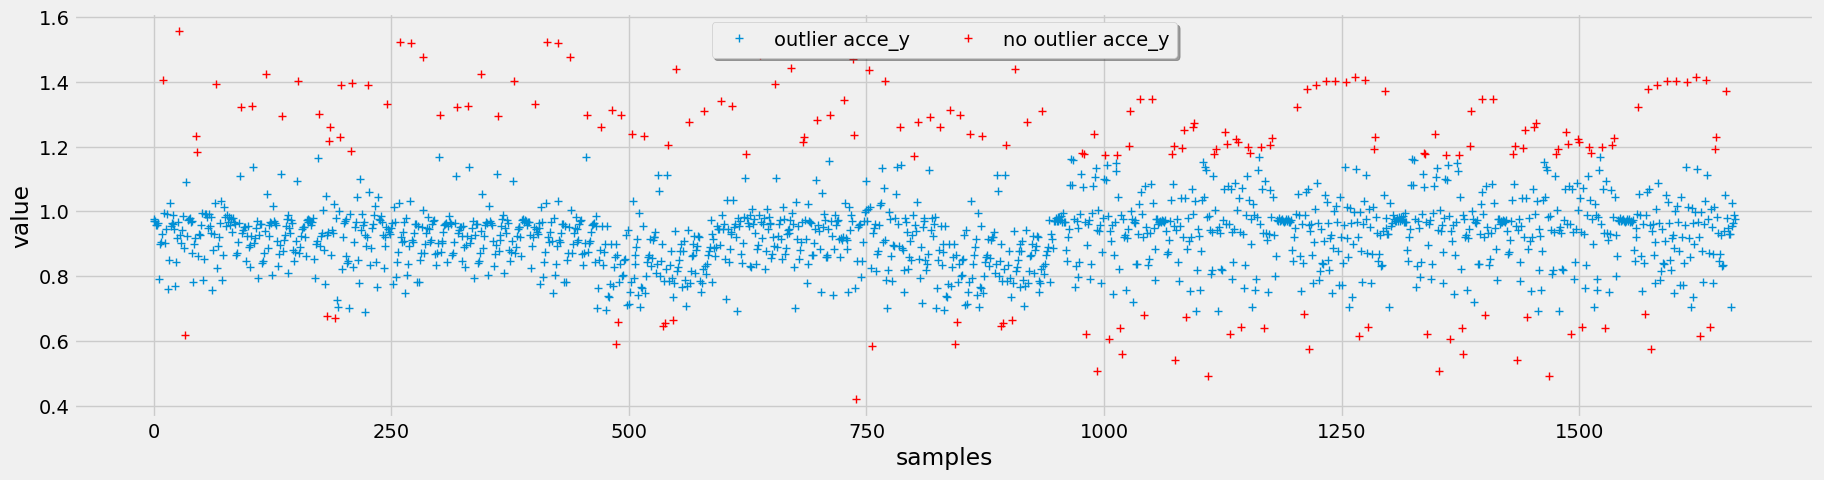

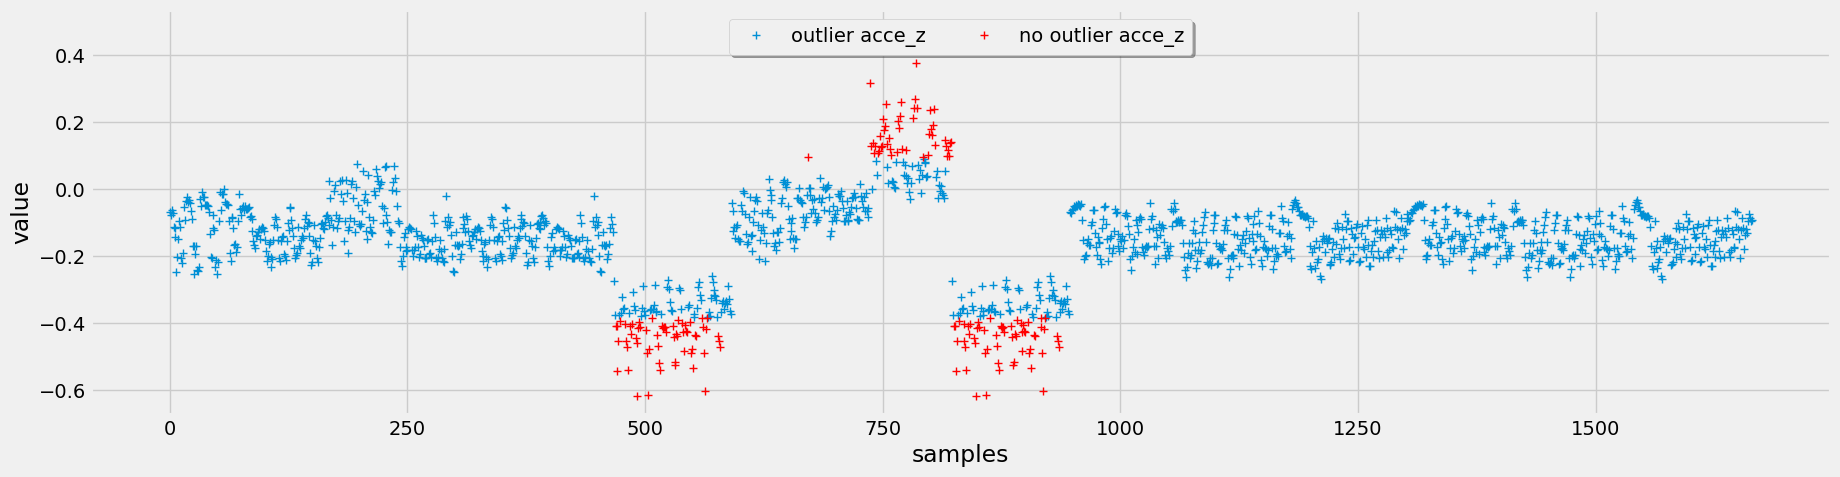

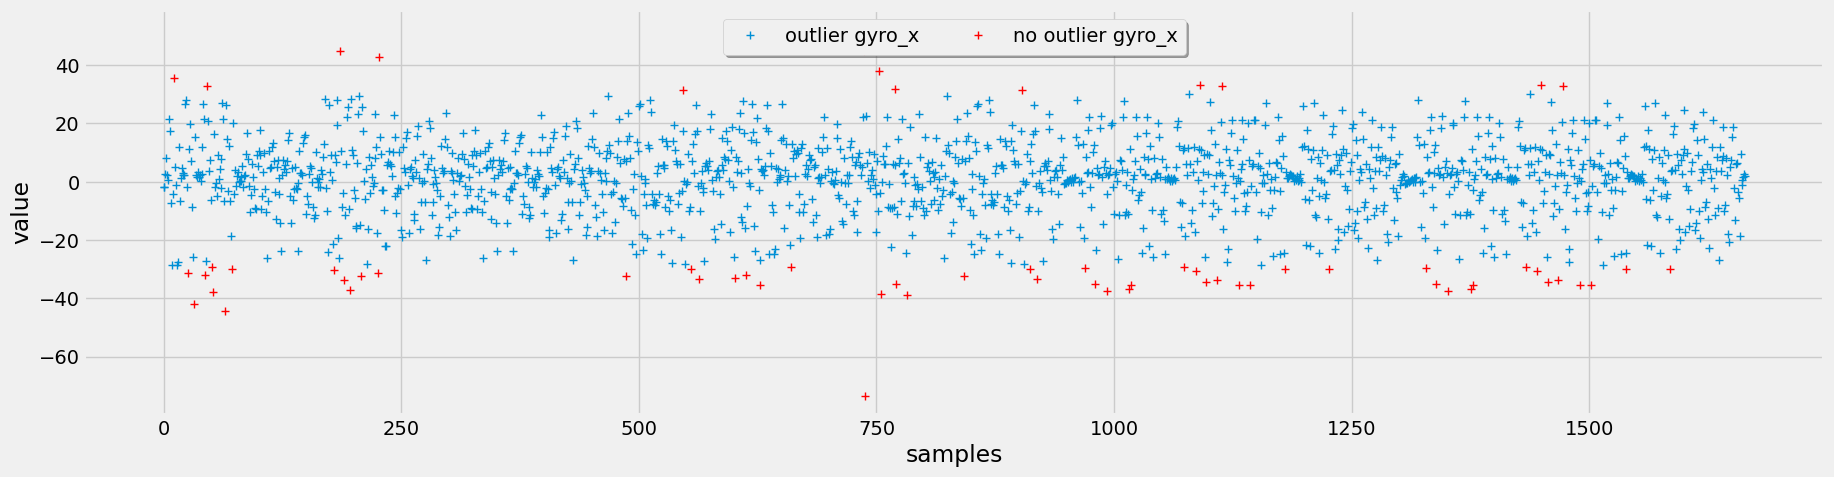

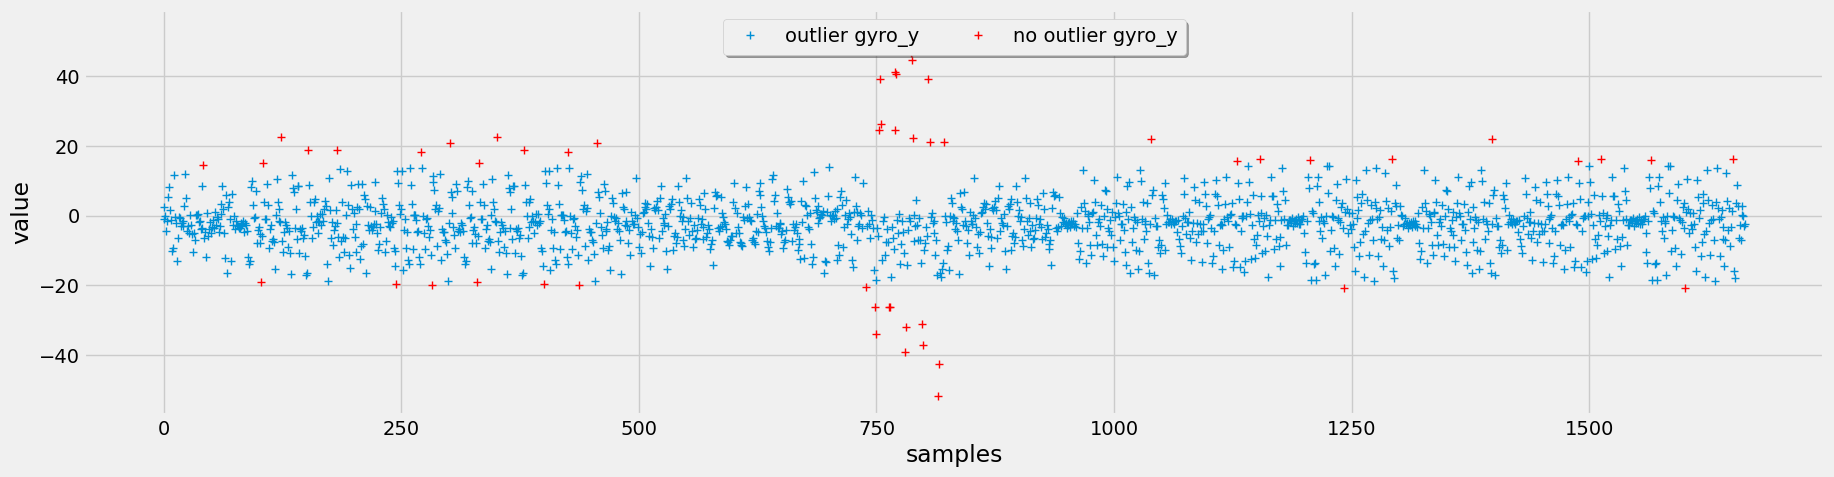

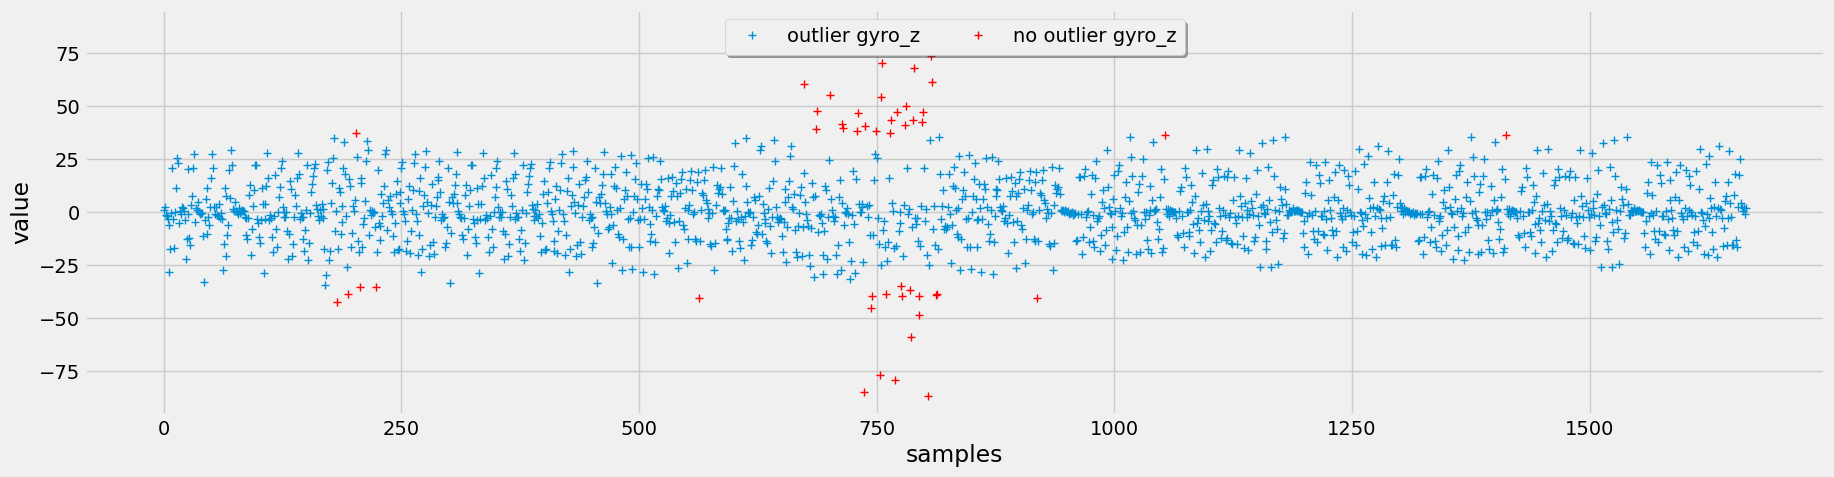

In [82]:
for perCol in outlierColumns:
    dataset = mark_outliers_iqr(df[df["label"] == label], perCol)
    plot_binary_outliers(
        dataset=dataset, 
        col=perCol, 
        outlier_col=perCol+"_outlier", 
        reset_index=True
        )

In [83]:
# Below uses the Chauvenet's Function to plot label == bench

In [85]:
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.
    
    Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption 
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset

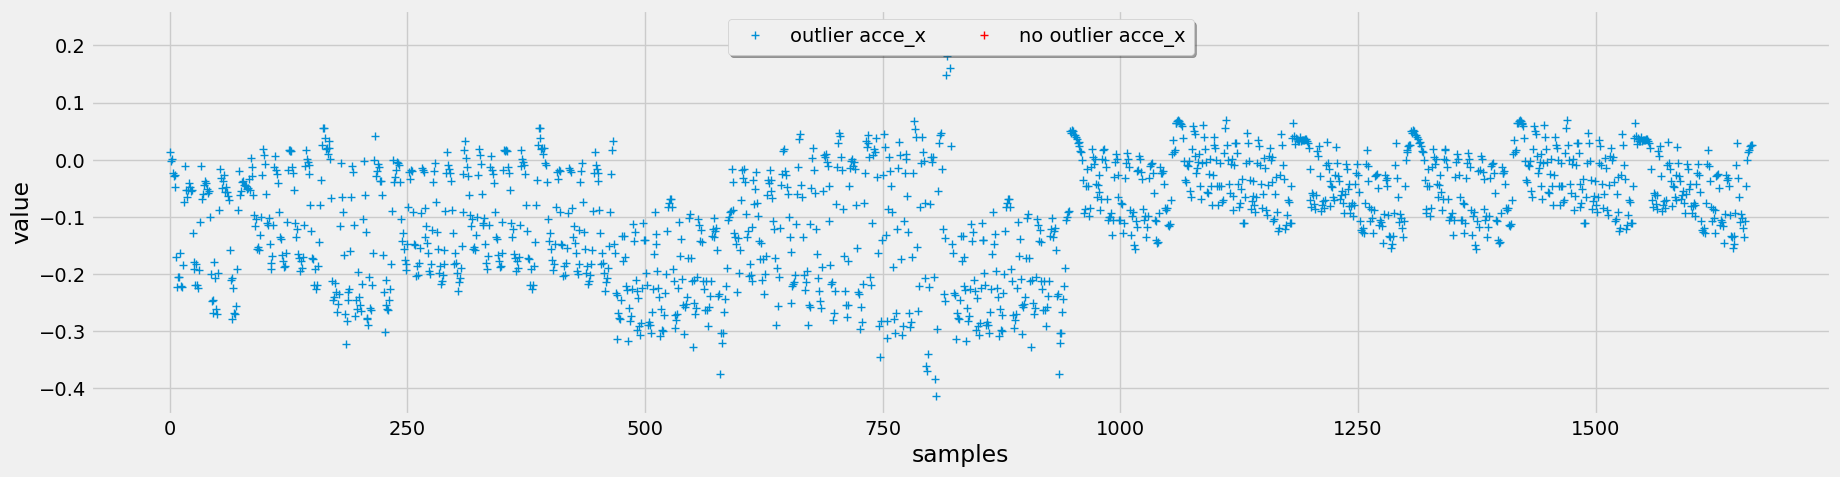

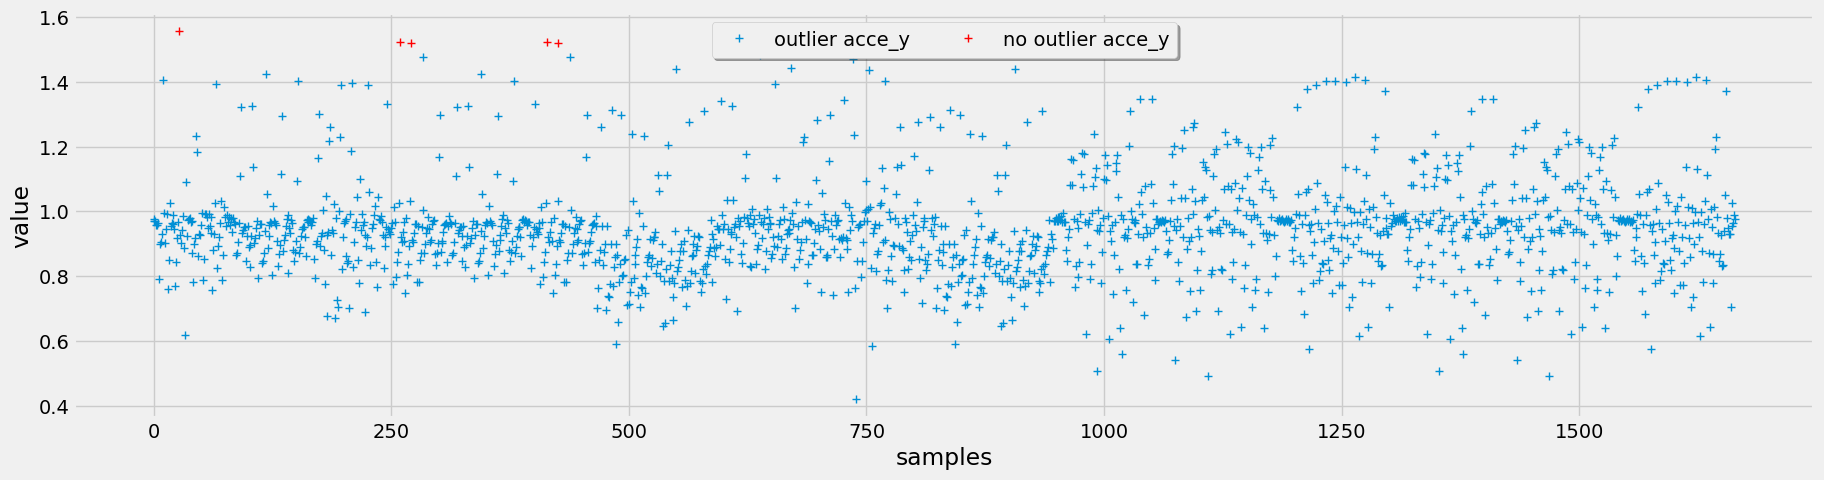

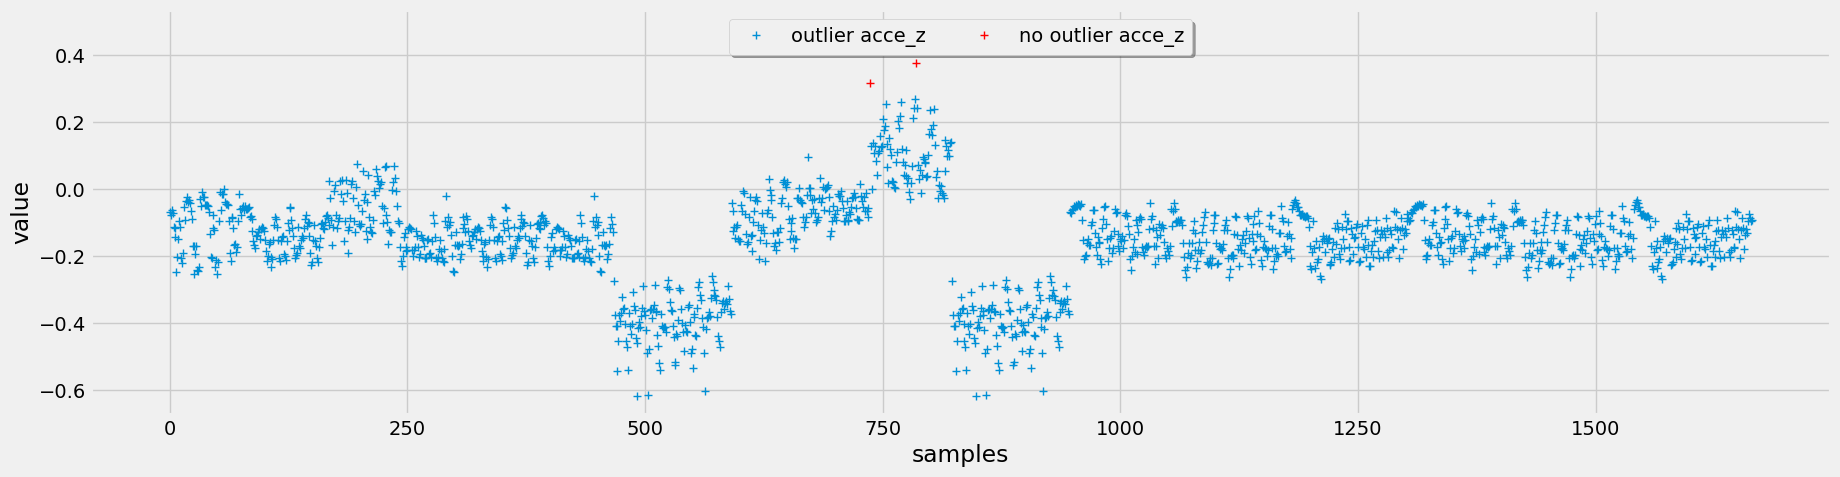

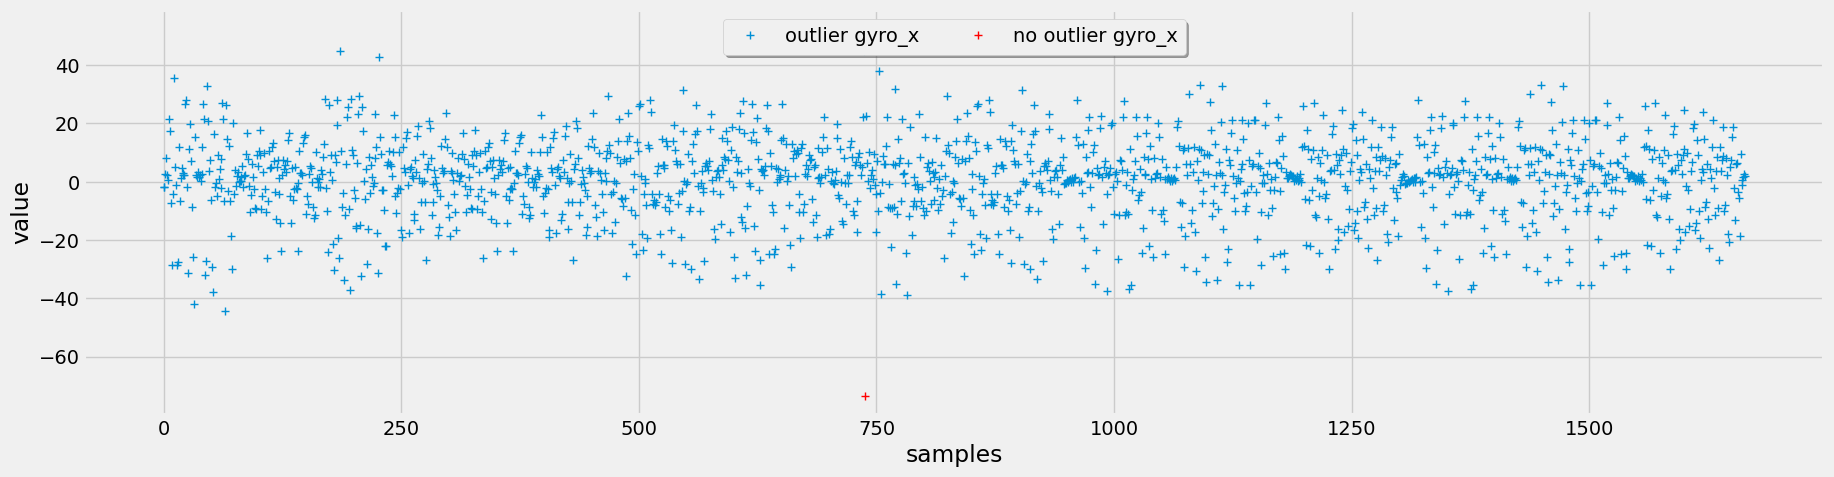

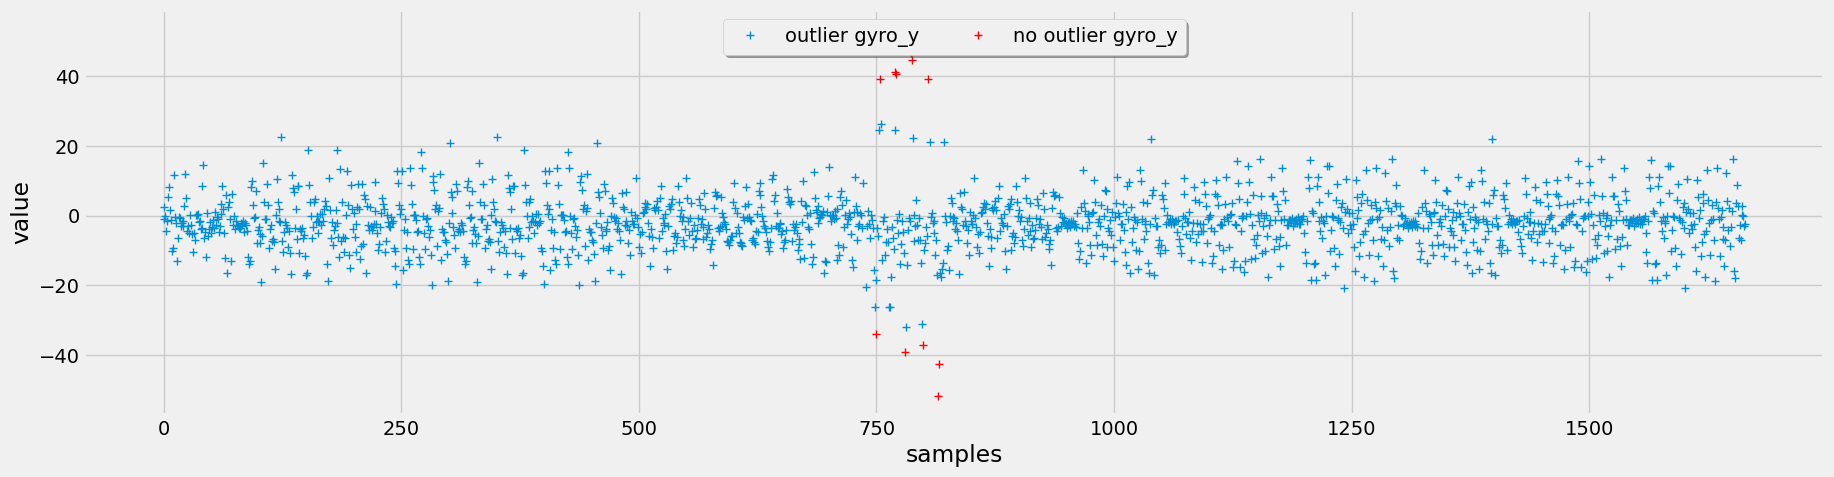

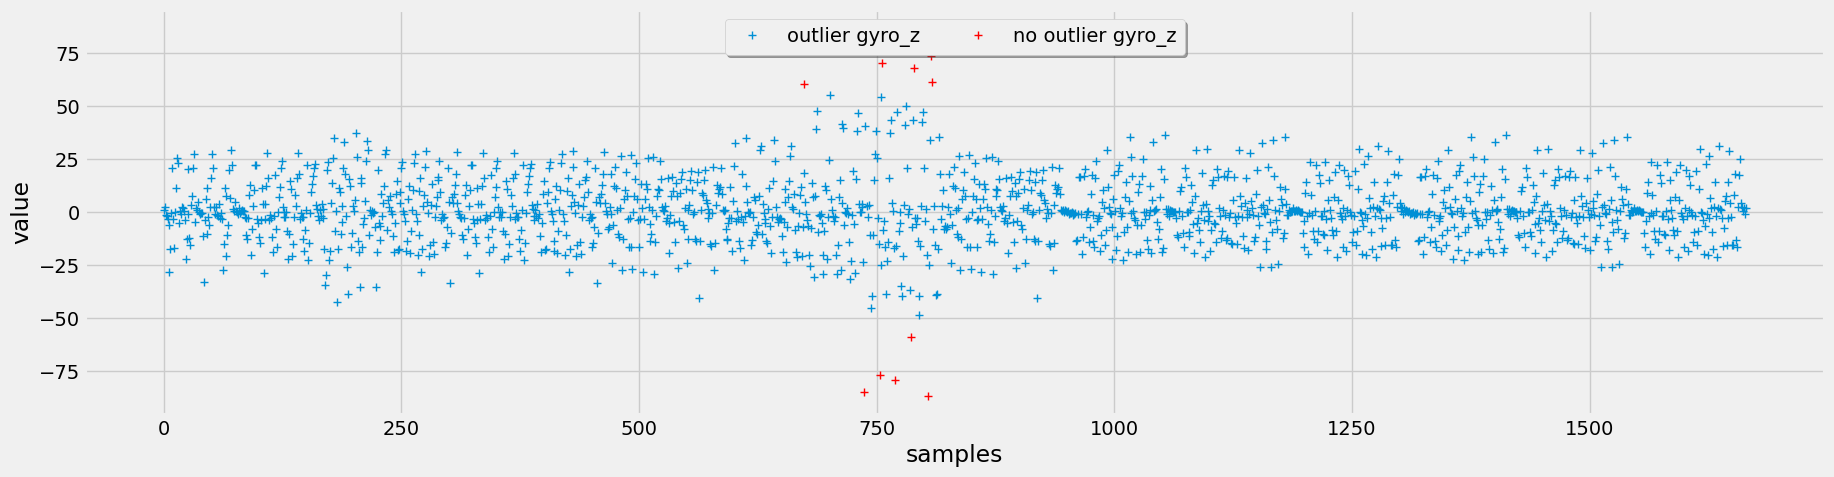

In [86]:
for perCol in outlierColumns:
    dataset = mark_outliers_chauvenet(df[df["label"] == label], perCol)
    plot_binary_outliers(
        dataset=dataset, 
        col=perCol, 
        outlier_col=perCol+"_outlier", 
        reset_index=True
        )

In [87]:
# Below uses the Local outlier factor Function to plot label == bench

In [88]:
def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.
    
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """
    
    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores

In [91]:
dataset, outliers, xScores = mark_outliers_lof(df[df["label"] == label], outlierColumns)

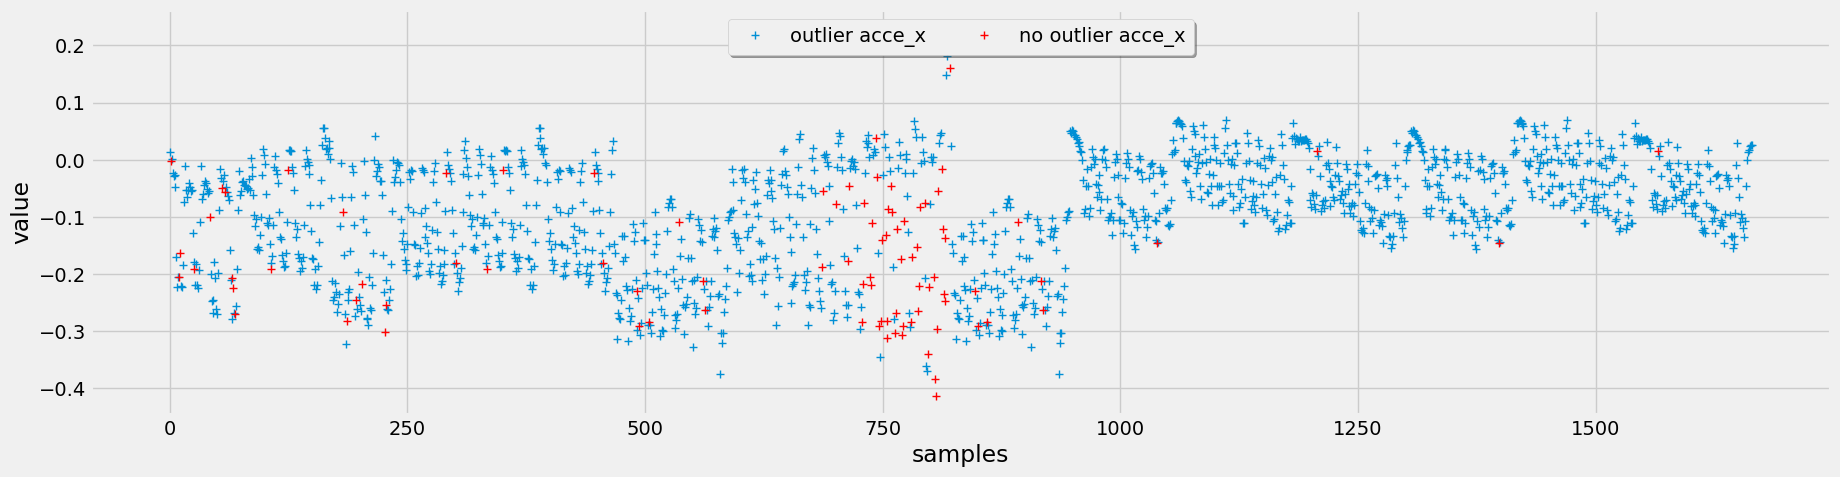

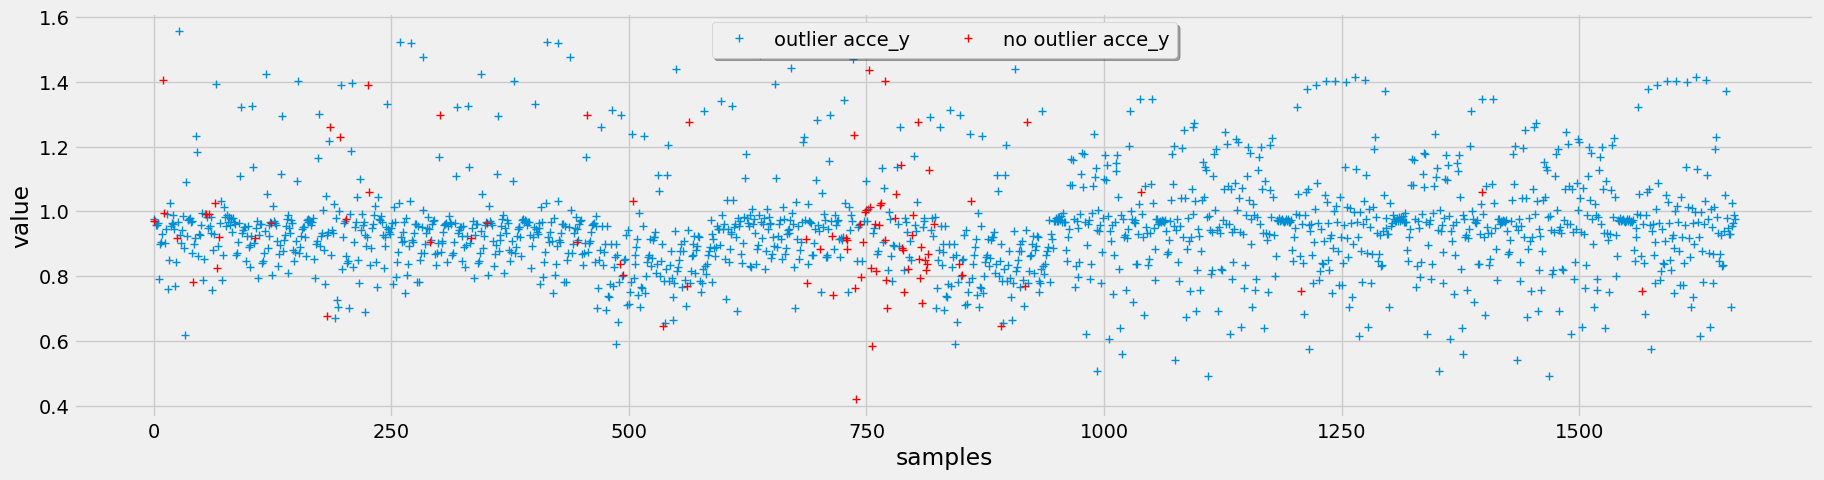

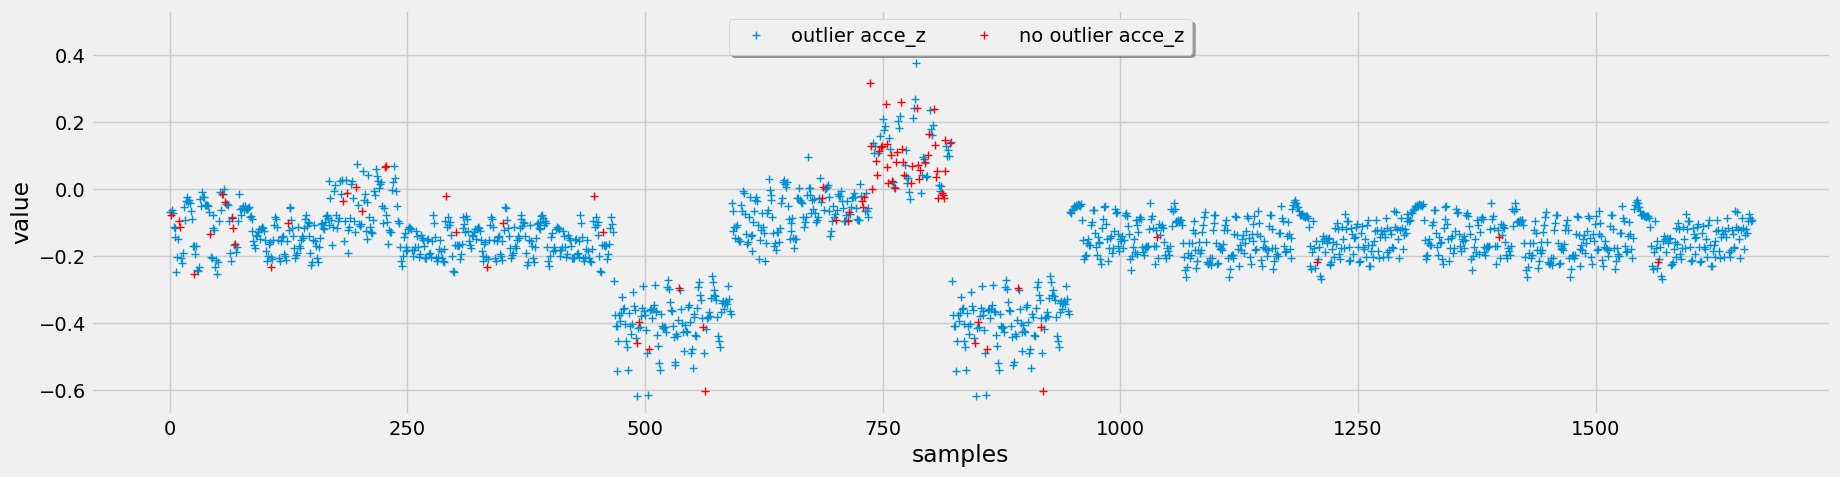

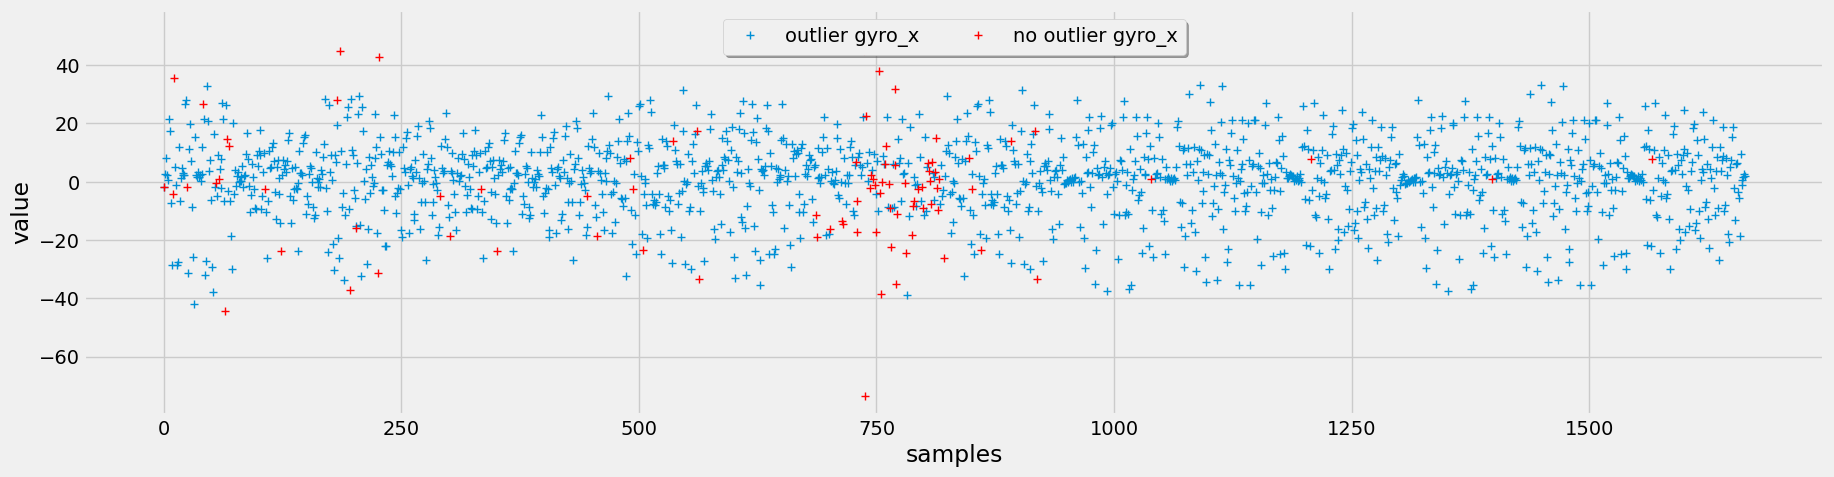

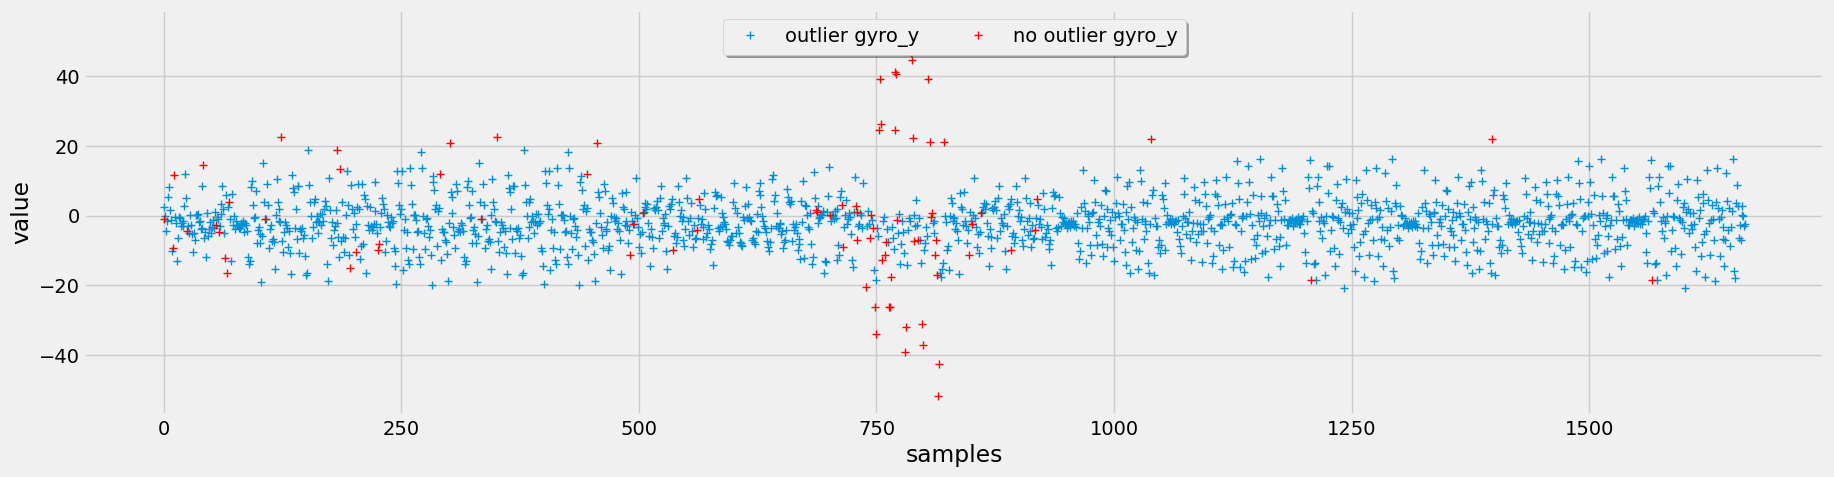

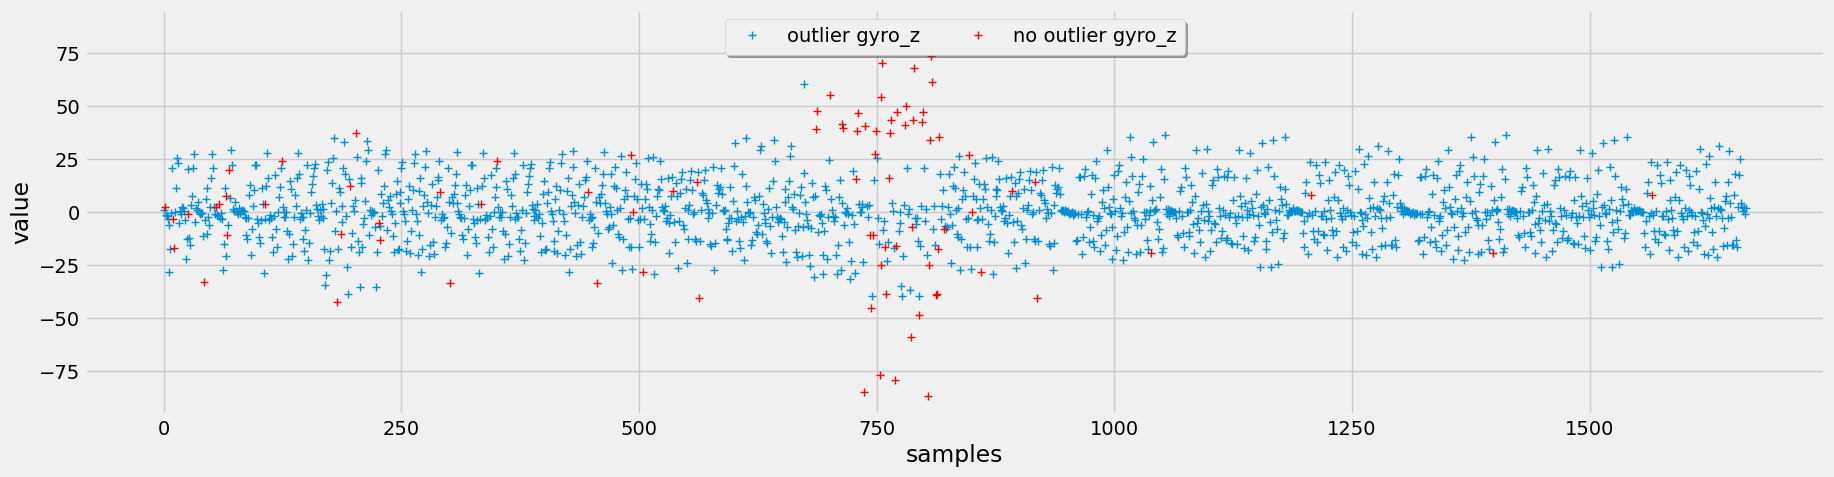

In [92]:
for perCol in outlierColumns:
    plot_binary_outliers(
        dataset=dataset, 
        col=perCol, 
        outlier_col="outlier_lof", 
        reset_index=True
        )

In [93]:
df

acce_x    acce_y    acce_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  
epoch (ms)                                                
2019-01-11 15:08:05.200           B  bench    heavy   30  
2019-01-11 15:08:05.400           B  bench    heavy   30  
2019-01-11 15:08:05.600           B  bench    heavy   30  
2019-01-11 15:08:05.800           B  bench    heavy   30  
2019-01-11 15:08:06.000           B  bench    heavy   30  
...                             ...    ...      ...  ...  
2019-01-20 17:33:27.000           E    row   medium   90  
2019-01-20 17:33:27.200           E    row   medium   90  
2019-01-20 17:33:27.400           E    row   medium   90  
2019-01-20 17:33:27.600           E    row   medium   90  
2019-01-20 17:33:27.800           E    row   medium   90  

[9009 rows x 10 columns]

In [94]:
col = "gyro_z"

In [95]:
dataset = mark_outliers_chauvenet(df, col=col)

In [96]:
dataset

acce_x    acce_y    acce_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  gyro_z_outlier  
epoch (ms)                                                                
2019-01-11 15:08:05.200           B  bench    heavy   30           False  
2019-01-11 15:08:05.400           B  bench    heavy   30           False  
2019-01-11 15:08:05.600           B  bench    heavy   30           False  
2019-01-11 15:08:05.800           B  bench    heavy   30           False  
2019-01-11 15:08:06.000           B  bench    heavy   30           False  
...                             ...    ...      ...  ...             ...  
2019-01-20 17:33:27.000           E    row   medium   90           False  
2019-01-20 17:33:27.200           E    row   medium   90           False  
2019-01-20 17:33:27.400           E    row   medium   90           False  
2019-01-20 17:33:27.600           E    row   medium   90           False  
2019-01-20 17:33:27.800           E    row   medium   90           False  

[9009 rows x 11 columns]

In [98]:
dataset["gyro_z_outlier"]

epoch (ms)
2019-01-11 15:08:05.200    False
2019-01-11 15:08:05.400    False
2019-01-11 15:08:05.600    False
2019-01-11 15:08:05.800    False
2019-01-11 15:08:06.000    False
                           ...  
2019-01-20 17:33:27.000    False
2019-01-20 17:33:27.200    False
2019-01-20 17:33:27.400    False
2019-01-20 17:33:27.600    False
2019-01-20 17:33:27.800    False
Name: gyro_z_outlier, Length: 9009, dtype: bool

In [105]:
dataset

acce_x    acce_y    acce_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  gyro_z_outlier  
epoch (ms)                                                                
2019-01-11 15:08:05.200           B  bench    heavy   30           False  
2019-01-11 15:08:05.400           B  bench    heavy   30           False  
2019-01-11 15:08:05.600           B  bench    heavy   30           False  
2019-01-11 15:08:05.800           B  bench    heavy   30           False  
2019-01-11 15:08:06.000           B  bench    heavy   30           False  
...                             ...    ...      ...  ...             ...  
2019-01-20 17:33:27.000           E    row   medium   90           False  
2019-01-20 17:33:27.200           E    row   medium   90           False  
2019-01-20 17:33:27.400           E    row   medium   90           False  
2019-01-20 17:33:27.600           E    row   medium   90           False  
2019-01-20 17:33:27.800           E    row   medium   90           False  

[9009 rows x 11 columns]

In [106]:
dataset.loc[dataset["gyro_z_outlier"], "gyro_z"] = np.nan

In [107]:
dataset

acce_x    acce_y    acce_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  gyro_z_outlier  
epoch (ms)                                                                
2019-01-11 15:08:05.200           B  bench    heavy   30           False  
2019-01-11 15:08:05.400           B  bench    heavy   30           False  
2019-01-11 15:08:05.600           B  bench    heavy   30           False  
2019-01-11 15:08:05.800           B  bench    heavy   30           False  
2019-01-11 15:08:06.000           B  bench    heavy   30           False  
...                             ...    ...      ...  ...             ...  
2019-01-20 17:33:27.000           E    row   medium   90           False  
2019-01-20 17:33:27.200           E    row   medium   90           False  
2019-01-20 17:33:27.400           E    row   medium   90           False  
2019-01-20 17:33:27.600           E    row   medium   90           False  
2019-01-20 17:33:27.800           E    row   medium   90           False  

[9009 rows x 11 columns]

In [108]:
dataset[dataset["gyro_z_outlier"]]

acce_x    acce_y    acce_z    gyro_x    gyro_y  \
epoch (ms)                                                                  
2019-01-14 13:57:41.800 -0.137000  1.495500  0.217000   33.9146   14.6462   
2019-01-18 17:22:40.600  0.915500 -0.302500 -0.047500   16.5364   30.1952   
2019-01-18 17:22:40.800  0.846667 -0.645667  0.174333  -49.5610   63.7196   
2019-01-18 17:22:49.600  1.363667  0.030000 -0.001333  -45.7196   -8.1218   
2019-01-18 17:22:49.800  0.707500  0.390500  0.181500 -100.5976  -33.9634   
2019-01-18 17:22:52.000  0.371333  0.580333  0.323333   44.3416   75.4390   
2019-01-18 17:22:52.200  0.744500  0.272000  0.261500   23.2562   22.4388   
2019-01-18 17:22:59.600  0.800000 -0.406333  0.121667  -35.7436   28.3414   
2019-01-18 17:25:40.400  0.623500 -0.247500  0.226000   -5.7562   55.8294   
2019-01-18 17:25:40.600  0.669333 -0.957000  0.440667  -48.6584   85.9266   
2019-01-18 17:26:04.800  1.115000 -0.792500  0.809000   91.5732   21.1710   
2019-01-18 17:26:05.000  0.714000 -0.101000  0.646000   98.5000  127.2804   
2019-01-18 17:26:07.400 -0.217667  0.465667  0.320333 -108.5002 -117.7196   
2019-01-18 17:26:07.600  0.616000 -0.205500  0.625000 -207.6098  -96.8414   
2019-01-18 17:26:07.800  1.070333 -1.238333  0.751000  -79.0244 -103.5126   
2019-01-18 17:26:09.400  0.773667 -1.072000  0.310000   -8.6950  -61.7318   
2019-01-18 17:26:09.600  1.464000 -0.902000  0.083000 -128.5364  -75.0488   
2019-01-18 17:26:09.800  0.709333 -0.014667 -0.120667 -235.5244 -187.9512   
2019-01-18 17:26:11.600  0.419000  0.175500 -0.176500  171.8048  103.7316   
2019-01-18 17:26:11.800  1.155333 -0.807667 -0.160333  -81.4878  233.1832   
2019-01-19 17:22:40.600  0.915500 -0.302500 -0.047500   16.5364   30.1952   
2019-01-19 17:22:40.800  0.846667 -0.645667  0.174333  -49.5610   63.7196   
2019-01-19 17:22:49.600  1.363667  0.030000 -0.001333  -45.7196   -8.1218   
2019-01-19 17:22:49.800  0.707500  0.390500  0.181500 -100.5976  -33.9634   
2019-01-19 17:22:52.000  0.371333  0.580333  0.323333   44.3416   75.4390   
2019-01-19 17:22:52.200  0.744500  0.272000  0.261500   23.2562   22.4388   
2019-01-19 17:22:59.600  0.800000 -0.406333  0.121667  -35.7436   28.3414   
2019-01-19 17:25:40.400  0.623500 -0.247500  0.226000   -5.7562   55.8294   
2019-01-19 17:25:40.600  0.669333 -0.957000  0.440667  -48.6584   85.9266   
2019-01-19 17:26:04.800  1.115000 -0.792500  0.809000   91.5732   21.1710   
2019-01-19 17:26:05.000  0.714000 -0.101000  0.646000   98.5000  127.2804   
2019-01-19 17:26:07.400 -0.217667  0.465667  0.320333 -108.5002 -117.7196   
2019-01-19 17:26:07.600  0.616000 -0.205500  0.625000 -207.6098  -96.8414   
2019-01-19 17:26:07.800  1.070333 -1.238333  0.751000  -79.0244 -103.5126   
2019-01-19 17:26:09.400  0.773667 -1.072000  0.310000   -8.6950  -61.7318   
2019-01-19 17:26:09.600  1.464000 -0.902000  0.083000 -128.5364  -75.0488   
2019-01-19 17:26:09.800  0.709333 -0.014667 -0.120667 -235.5244 -187.9512   
2019-01-19 17:26:11.600  0.419000  0.175500 -0.176500  171.8048  103.7316   
2019-01-19 17:26:11.800  1.155333 -0.807667 -0.160333  -81.4878  233.1832   
2019-01-20 17:22:40.600  0.915500 -0.302500 -0.047500   16.5364   30.1952   
2019-01-20 17:22:40.800  0.846667 -0.645667  0.174333  -49.5610   63.7196   
2019-01-20 17:22:49.600  1.363667  0.030000 -0.001333  -45.7196   -8.1218   
2019-01-20 17:22:49.800  0.707500  0.390500  0.181500 -100.5976  -33.9634   
2019-01-20 17:22:52.000  0.371333  0.580333  0.323333   44.3416   75.4390   
2019-01-20 17:22:52.200  0.744500  0.272000  0.261500   23.2562   22.4388   
2019-01-20 17:22:59.600  0.800000 -0.406333  0.121667  -35.7436   28.3414   
2019-01-20 17:25:40.400  0.623500 -0.247500  0.226000   -5.7562   55.8294   
2019-01-20 17:25:40.600  0.669333 -0.957000  0.440667  -48.6584   85.9266   
2019-01-20 17:26:04.800  1.115000 -0.792500  0.809000   91.5732   21.1710   
2019-01-20 17:26:05.000  0.714000 -0.101000  0.646000   98.5000  127.2804   
2019-01-20 17:26:07.400

In [109]:
dataset

acce_x    acce_y    acce_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  gyro_z_outlier  
epoch (ms)                                                                
2019-01-11 15:08:05.200           B  bench    heavy   30           False  
2019-01-11 15:08:05.400           B  bench    heavy   30           False  
2019-01-11 15:08:05.600           B  bench    heavy   30           False  
2019-01-11 15:08:05.800           B  bench    heavy   30           False  
2019-01-11 15:08:06.000           B  bench    heavy   30           False  
...                             ...    ...      ...  ...             ...  
2019-01-20 17:33:27.000           E    row   medium   90           False  
2019-01-20 17:33:27.200           E    row   medium   90           False  
2019-01-20 17:33:27.400           E    row   medium   90           False  
2019-01-20 17:33:27.600           E    row   medium   90           False  
2019-01-20 17:33:27.800           E    row   medium   90           False  

[9009 rows x 11 columns]

In [110]:
outlierColumns

['acce_x', 'acce_y', 'acce_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [111]:
df["label"].unique()

array(['bench', 'ohp', 'squat', 'dead', 'row', 'rest'], dtype=object)

In [112]:
outlierRemovedDF = df.copy() # copies the original DF.

In [113]:
outlierRemovedDF

acce_x    acce_y    acce_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  
epoch (ms)                                                
2019-01-11 15:08:05.200           B  bench    heavy   30  
2019-01-11 15:08:05.400           B  bench    heavy   30  
2019-01-11 15:08:05.600           B  bench    heavy   30  
2019-01-11 15:08:05.800           B  bench    heavy   30  
2019-01-11 15:08:06.000           B  bench    heavy   30  
...                             ...    ...      ...  ...  
2019-01-20 17:33:27.000           E    row   medium   90  
2019-01-20 17:33:27.200           E    row   medium   90  
2019-01-20 17:33:27.400           E    row   medium   90  
2019-01-20 17:33:27.600           E    row   medium   90  
2019-01-20 17:33:27.800           E    row   medium   90  

[9009 rows x 10 columns]

In [115]:
for perCol in outlierColumns:
    for perLabel in df["label"].unique():
        dataset = mark_outliers_chauvenet(
            df[df["label"] == perLabel], perCol
            )
        
        # This will dynamically replace outlier values to 
        # NaN to each column.
        dataset.loc[dataset[perCol + "_outlier"], perCol] = np.nan
        
        # Update the column in the original dataframe.
        # Very advance technique, I need to understand this.
        outlierRemovedDF.loc[(outlierRemovedDF["label"] == perLabel), perCol] = dataset[perCol]
        
        nOutliers = len(dataset) - len(dataset[perCol].dropna())
        print(f"Remove {nOutliers} from {perCol} for {perLabel}")

Remove 0 from acce_x for bench
Remove 2 from acce_x for ohp
Remove 0 from acce_x for squat
Remove 2 from acce_x for dead
Remove 0 from acce_x for row
Remove 0 from acce_x for rest
Remove 5 from acce_y for bench
Remove 6 from acce_y for ohp
Remove 0 from acce_y for squat
Remove 0 from acce_y for dead
Remove 0 from acce_y for row
Remove 0 from acce_y for rest
Remove 3 from acce_z for bench
Remove 6 from acce_z for ohp
Remove 0 from acce_z for squat
Remove 1 from acce_z for dead
Remove 0 from acce_z for row
Remove 0 from acce_z for rest
Remove 2 from gyro_x for bench
Remove 4 from gyro_x for ohp
Remove 1 from gyro_x for squat
Remove 6 from gyro_x for dead
Remove 0 from gyro_x for row
Remove 12 from gyro_x for rest
Remove 14 from gyro_y for bench
Remove 15 from gyro_y for ohp
Remove 9 from gyro_y for squat
Remove 14 from gyro_y for dead
Remove 10 from gyro_y for row
Remove 9 from gyro_y for rest
Remove 13 from gyro_z for bench
Remove 1 from gyro_z for ohp
Remove 12 from gyro_z for squat
Re

In [116]:
outlierRemovedDF

acce_x    acce_y    acce_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  
epoch (ms)                                                
2019-01-11 15:08:05.200           B  bench    heavy   30  
2019-01-11 15:08:05.400           B  bench    heavy   30  
2019-01-11 15:08:05.600           B  bench    heavy   30  
2019-01-11 15:08:05.800           B  bench    heavy   30  
2019-01-11 15:08:06.000           B  bench    heavy   30  
...                             ...    ...      ...  ...  
2019-01-20 17:33:27.000           E    row   medium   90  
2019-01-20 17:33:27.200           E    row   medium   90  
2019-01-20 17:33:27.400           E    row   medium   90  
2019-01-20 17:33:27.600           E    row   medium   90  
2019-01-20 17:33:27.800           E    row   medium   90  

[9009 rows x 10 columns]

In [117]:
outlierRemovedDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acce_x       9005 non-null   float64
 1   acce_y       8998 non-null   float64
 2   acce_z       8999 non-null   float64
 3   gyro_x       8984 non-null   float64
 4   gyro_y       8938 non-null   float64
 5   gyro_z       8945 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 739.0+ KB


In [118]:
# With the info(), we can see that our DF has some missing values which proves that the method works and converts that outlier values into "NaN".

In [119]:
outlierRemovedDF.to_pickle("../../data/interim/02_outlier_removed_chauvenet.pkl")

In [120]:
# Finally, saving the updated Dataframe (outlier removed using Chauvenet's Function) to the folder as pickle file.